# ■ 환경 설정 단계

In [ ]:
!pip install ratsnlp

############ 기본 라이브러리 ###############

import pandas as pd
import numpy as np
import json

############ 데이터 전처리 활용 #############
import re
import math
#############  데이터 탐색 활용  ############
# 폰트 관련 함수를 사용
import matplotlib.font_manager as fm
[f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
# 나눔 폰트 패키지를 업데이트하고 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
# 설치된 나눔 폰트를 matplotlib의 기본 폰트로 설정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
# 음수값을 마이너스로 표기 되게 설정
plt.rcParams['axes.unicode_minus'] = False
# matplotlib의 한글 폰트 캐시를 삭제
!rm -rf ~/.cache/matplotlib/
# 시각화 라이브러리
from wordcloud import WordCloud
import matplotlib.pyplot as plt

######## 모델링 관련 나머지 ########
!pip install transformers accelerate -U
from accelerate import Accelerator
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments
tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base")
model = BertForSequenceClassification.from_pretrained("beomi/kcbert-base", num_labels=60)
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.5/582.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.9 MB/s eta 0:00:00


Selecting previously unselected package fonts-nanum.
(Reading database ... 120872 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from ratsnlp.nlpbook.classification import ClassificationTrainArguments
args = ClassificationTrainArguments(
    pretrained_model_name = "beomi/kcbert-base",
    downstream_corpus_name= "nsmc",
    downstream_model_dir= "/gdrive/My Drive/Colab Notebooks/학위_10월",
    batch_size= 32 if torch.cuda.is_available() else 2,
    learning_rate=5e-5,
    max_seq_length=96,
    epochs=5,
    tpu_cores=0 if torch.cuda.is_available() else 8,
    seed=7,
)

In [ ]:
# 구글 드라이브와 연결

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# 랜덤 시드 고정  (고려)
#from ratsnlp import nlpbook
#nlpbook.set_seed(args)

In [ ]:
# 1.7 로거 설정 (고려 )
#nlpbook.set_logger(args)

cf. 로거 설정
- 로거는 학습 과정에서 정보나 오류,경고 등의 메시지를 기록해주는 도구이다.
- 모델 학습 시 다양한 정보인 epochs에서의 손실값, 정확도, 학습 시간등이 발생하게 되는데, 이러한 정보들을 시스템에 기록함으로써 나중에 학습 과정을 분석하거나 문제가 생길 때 원인을 찾는데 도움을 준다. 이러한 설정 과정은 체계적으로 모니터링하기 위해 필요하다.
- 용어 정리)
  - 손실값(Loss Value) : 손실값은 예측된 출력과 실제 값 사이의 차이다. 머신러닝 모델은 이 손실값을 최소화 해야한다. 모델이 학습하는 동안 손실값은 감소해야 올바르게 학습됨을 알 수 있다.
  - 정확도(Accuracy) : 분류 문제에서 모델의 성능을 평가하는 지표 중 하나로써 올바르게 분류됬는지 빙류로 계산한다. 100개의 데이터 중에서 95개를 분류했다면 정확도는 95%이다.
  - 학습 시간 : 모델을 학습하는데 걸리는 시간이다. 여러 요소인 모델의 복잡성, 데이터의 크기, 사용 하드웨어에 따라 학습 시간이 달라진다.
  - 데이터 셋을 섞는 이유 : 모델이 특정 순서나 패턴에 의존하게되면 일반화 성능이 떨어지기 때문에 데이터 셋을 섞는다.
  - 초기 가중치 설정: 모델의 가중치는 학습 시작 전에 랜덤한 값으로 초기화 된다. 이 초기화는 학습의 시작점을 정하고, 다양한 특징을 학습할 수 있다.
  - 드롭아웃 : 오버피팅(과적합)을 방지하는 규제 기법 중하나로써, 학습 중에 무작위로 일부 뉴런(노드)를 제거(비활성화)하여 모델이 특정 뉴런에 의존하지 않도록 한다.

즉, 다양한 데이터를 학습하고, 일반화 성능을 향상 시키며, 과적합을 방지하는 목적이 있다.

# ■ 드라마 댓글 데이터 : 불러오기 > 전처리 > 탐색 > 전처리

In [ ]:
#드라마 : 경이로운 소문
#경이로운 소문 불러오기
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021경이2_merged_file.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021경이_merged_file.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data1['drama_name'] = '경이로운소문'
data1['channel_name'] = '티비앤드라마'
data1['year'] = '2020'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data2['drama_name'] = '경이로운소문'
data2['channel_name'] = '티비앤드라마'
data2['year'] = '2020'
#두 데이터프레임 합치기
merged_rumor = pd.concat([data1,data2],ignore_index=True)
#합친 프레임 살펴보기
merged_rumor.head()

author                                               text  \
0   tvN D ENT  더 강력해진 카운터 vs 악귀,\r\n다시 악귀 잡으러 가자!\r\ntvN 토일드라...   
1  ASMR JU HA  시즌2도 잼있지만 진짜 시즌1은 역대급이다 특히 소문이 친구 여자애는 연기를 너무잘...   
2         임소리                     소문이를 보자마자 두근거림...이런남자가 세상에 잇다니   
3         김지환                                      와 발 싸이즈 다른거 봐   
4         ㅇㅅㅇ                    진짜 내가 무개념 민짜 촉법소년을 혐오하는 이유.....   

           published_at drama_name channel_name  year  label  
0  2023-07-12T02:46:12Z     경이로운소문       티비앤드라마  2020    NaN  
1  2023-08-15T17:50:54Z     경이로운소문       티비앤드라마  2020    NaN  
2  2023-08-15T08:20:29Z     경이로운소문       티비앤드라마  2020    NaN  
3  2023-08-14T23:25:31Z     경이로운소문       티비앤드라마  2020    NaN  
4  2023-08-14T23:23:32Z     경이로운소문       티비앤드라마  2020    NaN

In [ ]:
#드라마 : 스위트 홈 ,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021스위트홈1_merged.csv',encoding='cp949')
data4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021스위트홈2_merged.csv',encoding='cp949')
data5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021스위트홈3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data3['drama_name'] = '스위트홈'
data3['channel_name'] = '공작왕'
data3['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data4['drama_name'] = '스위트홈'
data4['channel_name'] = '리얼무비'
data4['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data5['drama_name'] = '스위트홈'
data5['channel_name'] = '지무비'
data5['year'] = '2021'
#두 데이터프레임 합치기
merged_sweethome= pd.concat([data3,data4,data5],ignore_index=True)
#합친 프레임 살펴보기
merged_sweethome.head()

author                                               text  \
0        라뷰라뷰ˇ  재밌게 잘 봤습니다\n다른곳에서 요약한 영상을 한번 봤는데\n여기는 거기보다 영상부...   
1         꾸미기잉                                           24:41:00   
2   dArkRush K                           정신 없는 드라마를 깔끔하게 잘 요약했네요ㅋ   
3         밀푀용기  원작을 안보고 봐도 뭔 내용 인지륾 모르겠고 10도 없고,, 기억나는건 넷플릭스 순...   
4  악동 암살자 (부계)           30:15\n??: 아저씨께 주님의 축복이 함께하기를\n??: 나 불교야   

           published_at label drama_name channel_name  year  
0  2023-08-09T12:37:12Z     9       스위트홈          공작왕  2021  
1  2023-08-07T08:12:07Z     8       스위트홈          공작왕  2021  
2  2023-07-30T17:17:03Z    10       스위트홈          공작왕  2021  
3  2023-07-08T07:30:00Z     4       스위트홈          공작왕  2021  
4  2023-06-28T12:18:00Z     9       스위트홈          공작왕  2021

In [ ]:
#드라마 : 빈센조
#데이터 불러오기
data6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021빈센조1_merged.csv',encoding='cp949')
data7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021빈센조2_merged.csv',encoding='cp949')
data8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021빈센조3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data6['drama_name'] = '빈센조'
data6['channel_name'] = '디글'
data6['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data7['drama_name'] = '빈센조'
data7['channel_name'] = '공작왕'
data7['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data8['drama_name'] = '빈센조'
data8['channel_name'] = '티비앤이엔티'
data8['year'] = '2021'
#두 데이터프레임 합치기
merged_vincenzo = pd.concat([data6,data7,data8],ignore_index=True)
#합친 프레임 살펴보기
merged_vincenzo.head()

author                                               text  \
0  디글 :Diggle  00:13? 1화 엔딩\n06:23? 2화 엔딩\n12:01? 3화 엔딩\n17:0...   
1           h                         빈센조역 이준혁배우가 해도 좋았다는 개인적인생각   
2         버틀러                                  지포라이퉐 저소리때문에 사버렷지   
3       단사과??                        편집도 이상하고..앞에 나래이션도 그지같고..ㅉㅉ   
4         손재승                                     조주빈같은놈들참교육해주세요   

           published_at drama_name channel_name  year  
0  2021-05-04T02:03:37Z        빈센조           디글  2021  
1  2023-07-02T03:17:16Z        빈센조           디글  2021  
2  2023-06-11T14:29:59Z        빈센조           디글  2021  
3  2023-06-03T22:27:39Z        빈센조           디글  2021  
4  2023-06-01T12:28:02Z        빈센조           디글  2021

In [ ]:
#드라마 : 민트 컨디션
#데이터 불러오기
merged_mintcondition = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021민트2_merged_drama.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_mintcondition['drama_name'] = '민트컨디션'
merged_mintcondition['channel_name'] = '고몽'
merged_mintcondition['year'] = '2021'
#합친 프레임 살펴보기
merged_mintcondition.head()

author                     text          published_at drama_name  \
0          꾸까꾸              예리임? 저 간호사?  2023-08-13T13:55:54Z      민트컨디션   
1  대조영 의형제 흑수돌       0:49 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ  2022-07-16T05:31:17Z      민트컨디션   
2            1  남진 브로 할때 나만 너무 북한어투 같음?  2022-03-06T12:59:38Z      민트컨디션   
3     Zzzzzzzz       연기잘하넹 ㅋㅋㅋ진짜 꼰대할배같음  2022-02-17T05:59:43Z      민트컨디션   
4          LYC             착용한 반지는 가짜죠?  2021-12-13T02:07:21Z      민트컨디션   

  channel_name  year  
0           고몽  2021  
1           고몽  2021  
2           고몽  2021  
3           고몽  2021  
4           고몽  2021

In [ ]:
#드라마 : 좋아하면 울리는,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data10 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021좋아1_merged_drama.csv',encoding='cp949')
data11 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021좋아2_merged_drama.csv',encoding='cp949')
data12 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021좋아3_merged_drama.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data10['drama_name'] = '좋아하면울리는'
data10['channel_name'] = '신기누설영화를그리다'
data10['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data11['drama_name'] = '좋아하면울리는'
data11['channel_name'] = '넷플릭스코리아'
data11['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data12['drama_name'] = '좋아하면울리는'
data12['channel_name'] = '신기누설영화를그리다'
data12['year'] = '2021'
#두 데이터프레임 합치기
merged_ringing_if_you_like_it= pd.concat([data10,data11,data12],ignore_index=True)
#합친 프레임 살펴보기
merged_ringing_if_you_like_it.head()

author                                               text  \
0  1727 Ska  여러분 신기누설님 적게 벌고 많이 벌으셔야 하니까 꼭 구독과 좋아요 눌러주세요 ㅎㅎ...   
1      예랑낭자                                 얼굴만 봐도 다시 좋아질거 같슴다   
2        윤후                              송강 얼굴이 사기다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ   
3        윤후      아니 김영규가 본다고 해서 봤는데 왜 이렇게 드라마가 오글거려 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ   
4         엄                         여기선 거리 감각이 만렙이여나 하나봐여.. ㅋㅋ   

           published_at drama_name channel_name  year  
0  2022-02-08T12:54:54Z    좋아하면울리는   신기누설영화를그리다  2021  
1  2023-08-12T09:20:43Z    좋아하면울리는   신기누설영화를그리다  2021  
2  2023-07-27T14:18:04Z    좋아하면울리는   신기누설영화를그리다  2021  
3  2023-07-27T14:10:38Z    좋아하면울리는   신기누설영화를그리다  2021  
4  2023-06-11T00:25:09Z    좋아하면울리는   신기누설영화를그리다  2021

In [ ]:
#드라마 : 덕구이즈백 ,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data13 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021덕구1_mereged_drama.csv')
data14 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021덕구1_mereged_drama.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data13['drama_name'] = '덕구이즈백'
data13['channel_name'] = '티비앤드라마'
data13['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data14['drama_name'] = '덕구이즈백'
data14['channel_name'] = '고몽'
data14['year'] = '2021'
#두 데이터프레임 합치기
merged_deoku_is_back = pd.concat([data13,data14],ignore_index=True)
#합친 프레임 살펴보기
merged_deoku_is_back.head()

author                               text          published_at  \
0    짝퉁 신씨                            결말이  머야  2022-02-08T09:26:07Z   
1  메피스토펠리스                      대깨문들을 보는거 같다.  2022-01-21T00:33:30Z   
2    aa aa                             ㄹㅇ 돈미새  2021-09-04T04:29:21Z   
3   Carina     와 아들을 몇번을 죽이는거냐.. 진짜 저렇게 끝이라고?  2021-08-31T20:32:15Z   
4       루루  에바다 그럼 10억때문에 사람두명이 죽은거잖아 진짜 참..ㅠ  2021-05-19T18:50:15Z   

  drama_name channel_name  year  
0      덕구이즈백       티비앤드라마  2021  
1      덕구이즈백       티비앤드라마  2021  
2      덕구이즈백       티비앤드라마  2021  
3      덕구이즈백       티비앤드라마  2021  
4      덕구이즈백       티비앤드라마  2021

In [ ]:
#드라마 : 박성실씨의 사차 산업혁명 ,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_parksungsil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021사차2_merged_drama.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_parksungsil['drama_name'] = '박성실씨의사차산업혁명'
merged_parksungsil['channel_name'] = '고몽'
merged_parksungsil['year'] = '2021'
#합친 프레임 살펴보기
merged_parksungsil.head()

author                                               text  \
0     다온  저렇게 ai가 한번에 딱딱 다 알아들으려면 얼마나 더 시간이 필요하려나 실제 지금 ...   
1     짱구  AI있어도 우리나라 미친새끼들은 보상뜯어내려고 고객센터전화하는 또라이들 많아서 절대...   
2   뭐하지닉  저런 스스로발전없는일 계속하지마세요. 저녁이나 주말이용해서 본인발전되는 공부하시고 ...   
3  박레원TV                         18:42  왜 이해가 되지? 마구니가 끼었나?   
4    박혜은                                              22:16   

           published_at   drama_name channel_name  year  
0  2023-06-23T16:59:19Z  박성실씨의사차산업혁명           고몽  2021  
1  2023-02-07T22:43:15Z  박성실씨의사차산업혁명           고몽  2021  
2  2022-03-09T14:09:32Z  박성실씨의사차산업혁명           고몽  2021  
3  2021-12-24T04:42:15Z  박성실씨의사차산업혁명           고몽  2021  
4  2021-11-02T02:13:12Z  박성실씨의사차산업혁명           고몽  2021

In [ ]:
#드라마 : 나빌레라
#데이터 불러오기
data15 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021나빌레라2_merged_drama.csv')
data16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021나빌레라2_merged_drama.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data15['drama_name'] = '나빌레라'
data15['channel_name'] = '달빛뮤즈'
data15['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data16['drama_name'] = '나빌레라'
data16['channel_name'] = '샾잉'
data16['year'] = '2021'
#두 데이터프레임 합치기
merged_navillera = pd.concat([data15,data16],ignore_index=True)
#합친 프레임 살펴보기
merged_navillera.head()

author                                               text  \
0     서하                       왕룽일가에서 박인환배우님연기에 놀랐던기억이 있습니다   
1     달빛  내 눈물꼭지였던 드라마.. 박인환 배우님 감사합니다 잔잔한 감동과 위로 전해주셔서 ...   
2  왕춘삼공공                                    ❤❤❤사랑임니다 덕출쒸!!!   
3   보우상!  1:00:25 나이가 들어도 슬프고 속상할땐 누구나 부모님을 찾는구나...왜 그렇게...   
4    김천수                 감동 임니다\n기역이가물거리는제가보면서뭉클해지고 눈물도흐름니다   

           published_at drama_name channel_name  year  
0  2023-05-15T08:12:37Z       나빌레라         달빛뮤즈  2021  
1  2023-01-05T16:15:02Z       나빌레라         달빛뮤즈  2021  
2  2022-10-13T12:35:03Z       나빌레라         달빛뮤즈  2021  
3  2022-06-05T04:59:25Z       나빌레라         달빛뮤즈  2021  
4  2022-01-26T04:01:23Z       나빌레라         달빛뮤즈  2021

In [ ]:
#드라마 : 당신의 운명을 쓰고 있습니다,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_your_destiny = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021당신1_당신의운명을쓰고있습니다_merged_drama.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_your_destiny['drama_name'] = '당신의운명을쓰고있습니다'
merged_your_destiny['channel_name'] = '고몽'
merged_your_destiny['year'] = '2021'

#합친 프레임 살펴보기
merged_your_destiny.head()

author                         text          published_at    drama_name  \
0  TVING  착한 운명 응원합니다 ?? 이건 모두 봐야 해!!  2021-03-29T08:56:54Z  당신의운명을쓰고있습니다   
1   해영 최               모레부터 1일할래요?ㅋㅋㅋ  2022-11-18T06:31:10Z  당신의운명을쓰고있습니다   
2    해링쓰           왜 내 운명을 끄적이는거야…!!!  2022-11-11T08:35:03Z  당신의운명을쓰고있습니다   
3   몰?루?                드라마 종합선물세트인가요  2022-10-31T21:10:06Z  당신의운명을쓰고있습니다   
4     베라                 도깨비 너낌 내려한건가  2022-02-27T08:35:19Z  당신의운명을쓰고있습니다   

  channel_name  year  
0           고몽  2021  
1           고몽  2021  
2           고몽  2021  
3           고몽  2021  
4           고몽  2021

In [ ]:
#드라마 : 마인,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data17 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021마인1_merged_drama.csv',encoding='cp949')
data18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021마인2_merged_drama.csv',encoding='cp949')
data19 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021마인3_merged_drama.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data17['drama_name'] = '마인'
data17['channel_name'] = '티비앤드라마'
data17['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data18['drama_name'] = '마인'
data18['channel_name'] = '디글'
data18['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data19['drama_name'] = '마인'
data19['channel_name'] = '하리봉무비'
data19['year'] = '2021'
#데이터프레임 합치기
merged_mine = pd.concat([data17,data18,data19],ignore_index=True)
#합친 프레임 살펴보기
merged_mine.head()

author                                           text  \
0       H Jin Lee      한자로 마인(魔人) 인줄 알았는데 \n영어로 마인(mine)이었던건가...   
1             야옹이  재벌가는 서로 죽이려는 것만 보다가 이렇게 서로 지켜주려는걸 보니 새롭고 멋지네요   
2              op                 통쾌한 여자들의 복수 멋지다 \n서로가 서로를 지키면서   
3             남로또                                              오   
4  dripedenreplay                                     이보영 존나 예쁘다   

           published_at drama_name channel_name  year  
0  2023-07-26T12:04:37Z         마인       티비앤드라마  2021  
1  2023-07-14T13:58:14Z         마인       티비앤드라마  2021  
2  2023-07-09T04:00:22Z         마인       티비앤드라마  2021  
3  2023-06-26T12:40:48Z         마인       티비앤드라마  2021  
4  2023-06-21T17:05:14Z         마인       티비앤드라마  2021

In [ ]:
#드라마 : 간 떨어지는 동거,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data20 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021간1_merged_drama.csv')
data21 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021간2_merged_drama.csv')
data22 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021간2_merged_drama.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data20['drama_name'] = '간떨어지는동거'
data20['channel_name'] = '샾잉'
data20['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data21['drama_name'] = '간떨어지는동거'
data21['channel_name'] = '티비앤드라마'
data21['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data22['drama_name'] = '간떨어지는동거'
data22['channel_name'] = '제이전의드라마와레시피'
data22['year'] = '2021'
#데이터프레임 합치기
merged_liver = pd.concat([data20,data21,data22],ignore_index=True)
#합친 프레임 살펴보기
merged_liver.head()

author                                   text          published_at  \
0   goodeunmi           도재진 맨날 울리고싶다....  우는것조차 댕댕이야  2023-04-18T15:48:46Z   
1  Beke Skwkw                    석선배랑 수경이 더 보여줬으면ㅠㅠㅠ  2023-04-17T21:28:46Z   
2           신              3천년간 솔로인것도 서러워 죽겟는데 ㅅㅂ...  2023-01-23T09:47:10Z   
3     mr park                          드라마 제목이 뭐예요??  2022-12-18T16:22:36Z   
4    fullmoon  혜리 완전 작전명순정 여주인 수애역할 잘어울릴것같다 드라마화되면 꼭  2022-10-15T14:12:50Z   

  drama_name channel_name  year  
0    간떨어지는동거           샾잉  2021  
1    간떨어지는동거           샾잉  2021  
2    간떨어지는동거           샾잉  2021  
3    간떨어지는동거           샾잉  2021  
4    간떨어지는동거           샾잉  2021

In [ ]:
#드라마 : 킹덤,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data23 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021킹덤1_merged.csv',encoding='cp949')
data24 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021킹덤2_mereged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data23['drama_name'] = '킹덤'
data23['channel_name'] = '리얼무비'
data23['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data24['drama_name'] = '킹덤'
data24['channel_name'] = '공작왕티비'
data24['year'] = '2021'
#두 데이터프레임 합치기
merged_kingdom = pd.concat([data23,data24],ignore_index=True)
#합친 프레임 살펴보기
merged_kingdom.head()

author                                               text  \
0      리얼무비  본 영상은 킹덤 시즌1 / 시즌2 / 아신전까지의 내용을 포함하고 있습니다! 재밌게...   
1  NewGenes  응 안봐. 믿고 거르는 김은희.  그 재밌다고 ㅈㄹ들 하던 시그널을 몇화 보다가 꺼...   
2     라뷰라뷰ˇ             이런거 잘 못 보는 사람인데\n덕분에 어떤 내용인지 잘 보았습니다!!   
3       김덕팔                             이거 안봤는데 시간 투자해서 볼만한가요?   
4       C U                      배두나+중전 연기만 빼면 모든게 완벽했던 드라마...   

           published_at drama_name channel_name  year  
0  2021-12-05T07:26:28Z         킹덤         리얼무비  2021  
1  2023-08-16T03:29:14Z         킹덤         리얼무비  2021  
2  2023-08-13T14:58:52Z         킹덤         리얼무비  2021  
3  2023-08-13T10:53:07Z         킹덤         리얼무비  2021  
4  2023-08-09T10:03:51Z         킹덤         리얼무비  2021

In [ ]:
#드라마 : 갯마을 차차차,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_ChaChaCha= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021갯마을3_merged_file_drama.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_ChaChaCha['drama_name'] = '갯마을차차차'
merged_ChaChaCha['channel_name'] = '영화와드라마'
merged_ChaChaCha['year'] = '2021'
#합친 프레임 살펴보기
merged_ChaChaCha.head()

author                                               text  \
0     이희열                                  드라마까지 더러운 학벌주의...   
1      개진                                    치대면 서울대보다 위 아닌가   
2     이경옥  선호씨는 얼레 멋져요 일박이일은  예능으로 열심히하고 드라마 연극은 온힘을 다해 노...   
3    양Zㅣ윤                       2:41 신민아 눈 똥그랗게 뜨는거 나만 귀엽냐ㅠㅜ   
4  찹쌀떡삼남매                          서울대 나오면 뭐해..\n\n눈치가 없는데..   

           published_at drama_name channel_name  year  
0  2023-06-30T05:55:51Z     갯마을차차차       영화와드라마  2021  
1  2023-06-26T14:28:33Z     갯마을차차차       영화와드라마  2021  
2  2022-09-14T07:14:59Z     갯마을차차차       영화와드라마  2021  
3  2022-05-30T11:31:02Z     갯마을차차차       영화와드라마  2021  
4  2022-05-18T13:03:18Z     갯마을차차차       영화와드라마  2021

In [ ]:
#드라마 : 지리산,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data25 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021지리산1_merged_drama.csv', encoding='cp949')
data26 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021지리산2_merged_drama.csv',encoding='utf-8')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data25['drama_name'] = '지리산'
data25['channel_name'] = '김단군'
data25['year'] = ''
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data26['drama_name'] = '지리산'
data26['channel_name'] = '티비앤드라마'
data26['year'] = ''
#데이터프레임 합치기
merged_jirisan = pd.concat([data25,data26],ignore_index=True)
#합친 프레임 살펴보기
merged_jirisan.head()

author                                  text          published_at  \
0       몽이곰이  단군님 제가 불안장애있는데 단군님 목소리들으니까 좋아요 감사합니다  2023-08-15T08:52:13Z   
1         흰둥           더문 리뷰 봤는데 역시 지리산만한 게 없다 ㅋㅋㅋ  2023-08-15T02:46:32Z   
2    첨지의럭키데이         ㅋㅋㅋㅋㅋㅋ 리뷰가 너무 웃겨서 지리산 보고 싶어지네  2023-07-31T03:07:47Z   
3     이세돌화이팅                  비상선언부터 여기까지왔습니다 ㅋㅋㅋㅋ  2023-07-12T08:46:05Z   
4  ! ulsanin                중국 자본 들어온건 다 망한다 봐야 함.  2023-07-09T07:58:45Z   

  drama_name channel_name year  
0        지리산          김단군       
1        지리산          김단군       
2        지리산          김단군       
3        지리산          김단군       
4        지리산          김단군

In [ ]:
#드라마 : 해피니스,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_happiness = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021해피니스1_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_happiness['drama_name'] = '해피니스'
merged_happiness['channel_name'] = '샾잉'
merged_happiness['year'] = '2021'
#합친 프레임 살펴보기
merged_happiness.head()

author                                               text  \
0     comma,r.t  나 아직도 시즌2 기다림… 연출도 서사도 스토리도 다 너무 좋았는데 내가 좋아하는 ...   
1           lik                                     나도 한효주랑 결혼하고싶다   
2           마카롱                         동이보다 이거보니 효주도 세월을 피해갈수 없구만   
3  언덕위에 있는 멤버놈들                   시즌2 아직도 기다리고 있다.. 블루레이라도..제발..ㅠㅠ   
4           김규리                                         이게 바로 마해자군   

           published_at drama_name channel_name  year  
0  2023-07-23T05:04:41Z       해피니스           샾잉  2021  
1  2023-07-17T10:54:40Z       해피니스           샾잉  2021  
2  2023-07-14T17:23:28Z       해피니스           샾잉  2021  
3  2023-07-08T06:57:03Z       해피니스           샾잉  2021  
4  2023-06-30T10:18:39Z       해피니스           샾잉  2021

In [ ]:
#드라마 : 배드 앤 크레이지,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data27 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/02배드2_merged_file_drama.csv')
data28 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/02배드3_merged_file_drama.csv')
data29 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/02배드_merged_file_drama.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data27['drama_name'] = '배드앤크레이지'
data27['channel_name'] = '고몽'
data27['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data28['drama_name'] = '배드앤크레이지'
data28['channel_name'] = '달빛뮤즈'
data28['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data29['drama_name'] = '배드앤크레이지'
data29['channel_name'] = '리뷰헤는밤'
data29['year'] = '2021'
#데이터프레임 합치기
merged_bad = pd.concat([data27,data28,data29],ignore_index=True)
#합친 프레임 살펴보기
merged_bad.head()

author                                               text  \
0           달빛뮤즈  《배드 앤 크레이지》 3, 4화\r\n금, 토 밤 10시 40분 tvN에서 시청하세...   
1  jingle jingle                  이거 진짜 재밌고 배우들 연기 개쩔었는데 너무 몼떴어 ㅠㅠㅠ   
2         커비별의요정                                  이사라가 마약보스 되다니 ㅋㅋㅋ   
3       Sori Kim                                     파이터클럽  ? -ㅋㅋㅋㅋ   
4        TPL[티플]                                        흑화한 계양심!ㅋㅋㅋ   

           published_at drama_name channel_name  year  
0  2021-12-26T01:09:46Z    배드앤크레이지           고몽  2021  
1  2023-06-10T19:34:33Z    배드앤크레이지           고몽  2021  
2  2023-03-19T14:55:21Z    배드앤크레이지           고몽  2021  
3  2023-01-15T12:36:32Z    배드앤크레이지           고몽  2021  
4  2022-08-23T13:49:06Z    배드앤크레이지           고몽  2021

In [ ]:
#드라마 : 불가살,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data30 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/불가살1_merged_file_drama.csv')
data31 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/불가살2_merged_file_drama.csv')
data32 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/불가살3_merged_file_drama.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data30['drama_name'] = '불가살'
data30['channel_name'] = '구불'
data30['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data31['drama_name'] = '불가살'
data31['channel_name'] = '자취방남자'
data31['year'] = '불가살'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data32['drama_name'] = '불가살'
data32['channel_name'] = '캡틴라미'
data32['year'] = '2021'
#두 데이터프레임 합치기
merged_bool = pd.concat([data30,data31,data32],ignore_index=True)
#합친 프레임 살펴보기
merged_bool.head()

author                                               text  \
0      구불  헉헉;; 시원하게 보시라고 한방에 올립니다. 구불가살..!!\n\n불가살 리뷰 나눠...   
1  우리 용재민                                 주인공님 약 광고 예전의 올렷떤데   
2      아륜                                 부부 싸움이 칼로 물베기 라잖아요   
3      축신  한편한편이 보통 드라마 분량 보다 길고 16화까지 있어 초반부는 엄청 재밌지만 중반...   
4     최석우                 불가살같은 존재가 되고싶다. 영원불멸 변하지 않는 젊은 몸~~   

           published_at drama_name channel_name  year  
0  2022-02-12T07:12:17Z        불가살           구불  2021  
1  2023-08-13T10:21:50Z        불가살           구불  2021  
2  2023-08-13T00:24:49Z        불가살           구불  2021  
3  2023-08-08T16:07:41Z        불가살           구불  2021  
4  2023-08-08T14:46:57Z        불가살           구불  2021

In [ ]:
#드라마 : 마녀 식당으로 오세요,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data33 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021마녀1_merged drama.csv',encoding='cp949')
data34 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021마인2_merged_drama.csv',encoding='cp949')
data35 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2021마녀3_merged_drama.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data33['drama_name'] = '마녀식당으로오세요'
data33['channel_name'] = '고몽'
data33['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data34['drama_name'] = '마녀식당으로오세요'
data34['channel_name'] = '티비앤드라마'
data34['year'] = '2021'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data35['drama_name'] = '마녀식당으로오세요'
data35['channel_name'] = 'ㅌㅂㅌㅂ티비'
data35['year'] = '2021'
#두 데이터프레임 합치기
merged_witch = pd.concat([data33,data34,data35],ignore_index=True)
#합친 프레임 살펴보기
merged_witch.head()

author                                               text  \
0       고몽  [마녀식당으로 오세요] 1화를 바로 관람할 수 있는 링크입니다. https://ww...   
1    우우우우린                                        악녀컨셉해도 잘하겠다   
2      젱젱젱                              ???: 야 종국이가 많이 귀여워하네~   
3     해영 최                         호텔델루나 재미있는데 비슷하다니까 한번 봐볼예정   
4  tpfialr                             마녀식당도 호텔델루나 느낌나서 너무 좋다   

           published_at drama_name channel_name  year  
0  2021-07-31T02:04:50Z  마녀식당으로오세요           고몽  2021  
1  2023-07-14T09:35:45Z  마녀식당으로오세요           고몽  2021  
2  2023-02-19T10:50:06Z  마녀식당으로오세요           고몽  2021  
3  2022-11-14T09:45:25Z  마녀식당으로오세요           고몽  2021  
4  2022-11-11T08:26:01Z  마녀식당으로오세요           고몽  2021

In [ ]:
#드라마 : 스물다섯,스물하나,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data36 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022스물1_merged.csv',encoding='cp949')
data37 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022스물2_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data36['drama_name'] = '스물다섯스물하나'
data36['channel_name'] = '구불'
data36['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data37['drama_name'] = '스물다섯스물하나'
data37['channel_name'] = '고몽'
data37['year'] = '2022'
#두 데이터프레임 합치기
merged_tweenty = pd.concat([data36,data37],ignore_index=True)
#합친 프레임 살펴보기
merged_tweenty.head()

author                                               text  \
0      고고고                       김태리 개 웃기네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ   
1       백야  Hay lam e xd g han quoc lam vo ah k???????????...   
2  The Bob                       저 시기에 저런 아버지들 엄청 많았을 것 같다...   
3   Ray Ra                백이진.. 현실에서는 일진 놀이. 이 감독의 인사이트는 정말..   
4      골키퍼                                      58초에 버리지말고 팔아   

           published_at drama_name channel_name  year  
0  2023-08-14T09:20:36Z   스물다섯스물하나           구불  2022  
1  2023-08-13T21:59:38Z   스물다섯스물하나           구불  2022  
2  2023-08-13T03:43:46Z   스물다섯스물하나           구불  2022  
3  2023-08-12T11:58:32Z   스물다섯스물하나           구불  2022  
4  2023-08-12T01:34:13Z   스물다섯스물하나           구불  2022

In [ ]:
#드라마 : 살인자의 쇼핑 목록,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data38 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022살인자1_merged.csv',encoding='cp949')
data39 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022살인자2_merged.csv',encoding='cp949')
data40 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022살인자3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data38['drama_name'] = '살인자의쇼핑목록'
data38['channel_name'] = '달빛뮤즈'
data38['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data39['drama_name'] = '살인자의쇼핑목록'
data39['channel_name'] = '디글'
data39['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data40['drama_name'] = '살인자의쇼핑목록'
data40['channel_name'] = '고몽'
data40['year'] = '2022'
#데이터프레임 합치기
merged_murderer = pd.concat([data38,data39,data40],ignore_index=True)
#합친 프레임 살펴보기
merged_murderer.head()

author                                             text  \
0          달빛뮤즈  《살인자의 쇼핑목록》 3, 4화\nhttps://youtu.be/Bqx57rzI9To   
1         아빠채널임                                    광수 배신할것 같아 ㅋㅋ   
2        mkiujm                                     아을돌았나 애미 즉일뻔   
3  Seyoung Yoon                        엄마만 두고 셔터 닫으면 어떻게 해 ㅋㅋㅋㅋㅋ   
4   넌 강해졌다 돌격해!                                 16:43 설현이 발차기 와우   

           published_at drama_name channel_name  year  
0  2022-05-07T00:15:01Z   살인자의쇼핑목록         달빛뮤즈  2022  
1  2022-12-21T12:56:18Z   살인자의쇼핑목록         달빛뮤즈  2022  
2  2022-06-18T02:04:46Z   살인자의쇼핑목록         달빛뮤즈  2022  
3  2022-06-07T06:24:37Z   살인자의쇼핑목록         달빛뮤즈  2022  
4  2022-06-02T03:14:54Z   살인자의쇼핑목록         달빛뮤즈  2022

In [ ]:
#드라마 : 괴이,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_strange = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022괴이1_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_strange['drama_name'] = '괴이'
merged_strange['channel_name'] = '달빛뮤즈'
merged_strange['year'] = '2022'
#합친 프레임 살펴보기
merged_strange.head()

author                    text          published_at drama_name  \
0     잉쿠키      16:24 이선생!!!!!!!!!  2023-06-03T05:41:55Z         괴이   
1    메가테크         5:08 상하이조!!?!?!  2022-08-17T13:22:56Z         괴이   
2    대박이다  군수점마새키는 여기서도 양아치짓거리네ㅋㅋ  2022-07-25T02:38:52Z         괴이   
3  수라백귀야행        인간주제 과거를 거스르려 들네  2022-07-08T16:10:20Z         괴이   
4  수라백귀야행        이래서 촉 좋은사람들은 안좋아  2022-07-08T15:46:57Z         괴이   

  channel_name  year  
0         달빛뮤즈  2022  
1         달빛뮤즈  2022  
2         달빛뮤즈  2022  
3         달빛뮤즈  2022  
4         달빛뮤즈  2022

In [ ]:
#드라마 : 오피스에서 뭐하share,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data41 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022오피스1_merged.csv',encoding='cp949')
data42 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022오피스2_merged.csv',encoding='cp949')
data43 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022오피스3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data41['drama_name'] = '오피스에서뭐하쉐얼'
data41['channel_name'] = '디글'
data41['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data42['drama_name'] = '오피스에서뭐하쉐얼'
data42['channel_name'] = '티비앤드라마'
data42['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data43['drama_name'] = '오피스에서뭐하쉐얼'
data43['channel_name'] = '티비앤드라마'
data43['year'] = '2022'
#두 데이터프레임 합치기
merged_office = pd.concat([data41,data42,data43],ignore_index=True)
#합친 프레임 살펴보기
merged_office.head()

author                                      text          published_at  \
0   Rozi   설레여 ㅎㅎㅎㅎ 이학주 진짜 현실에 있을 거 같은데 전혀 없는 사람..  2023-08-14T18:09:04Z   
1    김서진               너무 재밌어서 콧구멍 벌렁거린다 하 이학주 사랑해  2023-08-03T11:40:16Z   
2   뭉게구름  개인적으로 팬이되었네요.\n첫 주연인듯 한데...\n계속 승승장구 하시길  2023-06-20T16:06:50Z   
3    김도균                       이 배우 기대된다. 잘 됐음 좋겠당  2023-03-15T07:49:22Z   
4  아에이오우                  학주님 로맨스 많이 찍어주세요 ㅠㅠㅠㅠㅠㅠㅠ  2023-02-17T07:54:02Z   

  drama_name channel_name  year  
0  오피스에서뭐하쉐얼           디글  2022  
1  오피스에서뭐하쉐얼           디글  2022  
2  오피스에서뭐하쉐얼           디글  2022  
3  오피스에서뭐하쉐얼           디글  2022  
4  오피스에서뭐하쉐얼           디글  2022

In [ ]:
#드라마 : 링크 먹고 사랑하라 죽이게,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data44 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022링크1_merged.csv',encoding='cp949')
data45 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022링크2_merged.csv',encoding='cp949')
data46 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022링크3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data44['drama_name'] = '링크먹고사랑하라죽이게'
data44['channel_name'] = '고몽'
data44['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data45['drama_name'] = '링크먹고사랑하라죽이게'
data45['channel_name'] = '티비앤드라마'
data45['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data46['drama_name'] = '링크먹고사랑하라죽이게'
data46['channel_name'] = '디글'
data46['year'] = '2022'
#데이터프레임 합치기
merged_link = pd.concat([data44,data45,data46],ignore_index=True)
#합친 프레임 살펴보기
merged_link.head()

author                                               text  \
0               고몽       다음편 3-4회 리뷰 나왔다 https://youtu.be/VwXkADvEYj4   
1  넘버원아이템#no1items                                          네 재밌어요 ㅎㅎ   
2               아리  여러분 아직도 안보셨다면 꼭 보세요 호텔델루나랑 여신강림 좋아해서 찾아봤는데 미친 ...   
3              이은진                               그래서 둘이 언제 사겨요???!!!!   
4              김새결      링크현상ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 뭔가 진짜 과학적으론 아니지만 있을꺼 같은..ㅋㅋㅋ   

           published_at   drama_name channel_name  year  
0  2022-06-17T08:31:35Z  링크먹고사랑하라죽이게           고몽  2022  
1  2023-04-18T07:04:48Z  링크먹고사랑하라죽이게           고몽  2022  
2  2023-02-26T04:05:52Z  링크먹고사랑하라죽이게           고몽  2022  
3  2022-11-10T15:08:20Z  링크먹고사랑하라죽이게           고몽  2022  
4  2022-11-08T03:56:02Z  링크먹고사랑하라죽이게           고몽  2022

In [ ]:
#드라마 : 환혼,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data47 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022환혼1_merged.csv',encoding='cp949')
data48 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022환혼2_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data47['drama_name'] = '환혼'
data47['channel_name'] = '티비앤드라마'
data47['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data48['drama_name'] = '환혼'
data48['channel_name'] = '명작맛집'
data48['year'] = '2022'
#두 데이터프레임 합치기
merged_soul = pd.concat([data47,data48],ignore_index=True)
#합친 프레임 살펴보기
merged_soul.head()

author                                               text  \
0  test test                          정소민.. 정소민.. 정소민.. 팬 됐다..?   
1         소미  요거지~~ \n23년 7월 tvn재방을 또 보고있음^^\n환혼은 우리우기덕이가 최고...   
2     바람에베이다                           자막 오류~! 전기구이가 아닌 직화 구이~!   
3        강씨익                           아 쟤 그 사람이었구나 나쁜엄마에 도둑놈자슥   
4       새싹짱균                                     하 언제봐도 재밌다 환혼은   

           published_at drama_name channel_name  year  
0  2023-07-23T02:26:00Z         환혼       티비앤드라마  2022  
1  2023-07-23T01:40:51Z         환혼       티비앤드라마  2022  
2  2023-06-28T03:25:47Z         환혼       티비앤드라마  2022  
3  2023-06-22T09:58:24Z         환혼       티비앤드라마  2022  
4  2023-06-17T18:22:04Z         환혼       티비앤드라마  2022

In [ ]:
#드라마 : 아파트는 아름다워,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data49 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022아파트1_merged.csv',encoding='cp949')
data50 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022아파트3_meregd.csv',encoding='utf-8')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data49['drama_name'] = '아파트는아름다워'
data49['channel_name'] = '달빛뮤즈'
data49['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data50['drama_name'] = '아파트는아름다워'
data50['channel_name'] = '티비앤이앤티'
data50['year'] = '2022'
#두 데이터프레임 합치기
merged_apartment = pd.concat([data49,data50],ignore_index=True)
#합친 프레임 살펴보기
merged_apartment.head()

author                                               text  \
0    잘살아보세                                            어른들이 문제   
1      이유민                                왜캐 귀잖게 아파트 로 급을 나눔?   
2   인성문제있어                                        우리집 문짝이 쉐눈데   
3  センスイシノブ  이거는 실제로 초딩들 사이에서 일어나고있는 실제 일을 드라마로 만든거 참 어이가 없...   
4       훈이                             아파트도 차별..차도 차별..허허헣...   

           published_at drama_name channel_name  year  
0  2023-08-02T01:22:02Z   아파트는아름다워         달빛뮤즈  2022  
1  2023-03-15T07:13:00Z   아파트는아름다워         달빛뮤즈  2022  
2  2023-02-04T16:38:36Z   아파트는아름다워         달빛뮤즈  2022  
3  2022-09-05T11:27:06Z   아파트는아름다워         달빛뮤즈  2022  
4  2022-09-03T13:29:47Z   아파트는아름다워         달빛뮤즈  2022

In [ ]:
#드라마 : 스톡오브 하이스쿨,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data51 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022스톡1_merged.csv')
data52 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022스톡2_merged.csv')
data53 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022스톡3_merged.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data53['drama_name'] = '스톡오브하이스쿨'
data53['channel_name'] = '캡틴라미'
data53['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data51['drama_name'] = '스톡오브하이스쿨'
data51['channel_name'] = '티비앤드라마'
data51['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data52['drama_name'] = '스톡오브하이스쿨'
data52['channel_name'] = '티비앤이앤티'
data52['year'] = '2022'
#데이터프레임 합치기
merged_school = pd.concat([data51,data52,data53],ignore_index=True)
#합친 프레임 살펴보기
merged_school.head()

author                                               text  \
0     랄랄라 야옹           아니 뭐야 썸네일 낚시임? 썸네일은 외국인 영상 올려놓고, 한국인 작품?   
1        조용준            14:50\n조대부고 이완 \n화이팅 마라탕 화이팅\n엉덩이탐정 화이팅   
2  wezeb lee  실수를 책임져줄 경재적으로 든든한 부모가 없으면 미래를 꿈 꾸기도 전에 망가진채로 ...   
3     Dima S  어렸을때 소액으로 깡통차봐야 진짜 어른이 돼서 신중한 투자를 하게 되고\n나이먹고 ...   
4        천사표  현실을 너무 모르는 드라마...\n이런 망상만 심어주는 드라마가 젊은이를 파산으로 ...   

           published_at drama_name channel_name  year  
0  2022-11-18T19:35:11Z   스톡오브하이스쿨       티비앤드라마  2022  
1  2022-09-02T00:53:58Z   스톡오브하이스쿨       티비앤드라마  2022  
2  2022-07-30T20:16:40Z   스톡오브하이스쿨       티비앤드라마  2022  
3  2022-07-30T19:10:15Z   스톡오브하이스쿨       티비앤드라마  2022  
4  2022-07-30T14:36:49Z   스톡오브하이스쿨       티비앤드라마  2022

In [ ]:
#드라마 : 아다마스,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data53 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022아다마스1_merged.csv',encoding='cp949')
data54 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022아다마스2_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data53['drama_name'] = '아다마스'
data53['channel_name'] = '달타냥시네마'
data53['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data54['drama_name'] = '아다마스'
data54['channel_name'] = '고몽'
data54['year'] = '2022'
#두 데이터프레임 합치기
merged_adamas = pd.concat([data53,data54],ignore_index=True)
#합친 프레임 살펴보기
merged_adamas.head()

author                      text          published_at drama_name  \
0    박우리  아마다스 아다마스 아 다마스!! 헷갈려 ㅋㅋ  2023-05-29T21:18:36Z       아다마스   
1      민             경영이 형 여기도 나오네  2023-04-30T15:38:28Z       아다마스   
2   인재 원     괞찮은거같은데 좀 오버가너머 많다는거지  2023-03-23T09:16:14Z       아다마스   
3     미미                         ?  2023-03-21T15:46:10Z       아다마스   
4    조터치             오오~~\n재미있다요!!  2023-02-27T10:19:23Z       아다마스   

  channel_name  year  
0       달타냥시네마  2022  
1       달타냥시네마  2022  
2       달타냥시네마  2022  
3       달타냥시네마  2022  
4       달타냥시네마  2022

In [ ]:
#드라마 : 바벨신드롬,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_Babelsyndrome = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022바벨신드롬2_merged.csv')
merged_Babelsyndrome['drama_name'] = '바벨신드롬'
merged_Babelsyndrome['channel_name'] = '티비앤드라마'
merged_Babelsyndrome['year'] = '2022'
#합친 프레임 살펴보기
merged_Babelsyndrome.head()

author               text          published_at drama_name channel_name  \
0  🗣수구리🗣  👍🏾👍🏾👍🏾))👏((👍🏾👍🏾👍🏾  2022-07-31T13:41:06Z      바벨신드롬       티비앤드라마   
1     윤주              ❤️ 심쿵  2022-07-30T22:50:06Z      바벨신드롬       티비앤드라마   
2    김수로         추영우좋아요..❤️  2022-07-30T19:03:51Z      바벨신드롬       티비앤드라마   

   year  
0  2022  
1  2022  
2  2022

In [ ]:
#드라마 : 빅마우스,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data56 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022빅마우스1_merged.csv',encoding='cp949')
data57 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022빅마우스2_merged.csv',encoding='cp949')
data58 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022빅마우스3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data56['drama_name'] = '빅마우스'
data56['channel_name'] = '무비랜드'
data56['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data57['drama_name'] = '빅마우스'
data57['channel_name'] = '어바웃타임'
data57['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data58['drama_name'] = '빅마우스'
data58['channel_name'] = '엠뚜루마뚜'
data58['year'] = '2022'
#두 데이터프레임 합치기
merged_bigmouse = pd.concat([data56,data57,data58],ignore_index=True)
#합친 프레임 살펴보기
merged_bigmouse.head()

author                                               text  \
0         전일우                                               2:33   
1         김하늘  처음에는 흥미 진진 하더나 무슨 만물 빅마우스 설이여 뭐여 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...   
2         정모씨  처음엔 재밌게 봤지만 밑도 끝도 없이 그림에 큰그림 큰큰그림 큰큰큰그림.. 그리니까...   
3  gobrin KIM  10화 까지의 명작을 다음 화 부터 개박살 내버린 용두 사미의 최고봉 드라마 ......   
4       알바트로슝                               한국드라마에선 아반떼가 슈퍼카여~ㅎㅎ   

           published_at drama_name channel_name  year  
0  2023-08-12T16:31:48Z       빅마우스         무비랜드  2022  
1  2023-08-11T18:34:34Z       빅마우스         무비랜드  2022  
2  2023-08-11T17:57:50Z       빅마우스         무비랜드  2022  
3  2023-08-11T09:17:43Z       빅마우스         무비랜드  2022  
4  2023-08-06T12:56:54Z       빅마우스         무비랜드  2022

In [ ]:
#드라마 : 조선 정신과 의사 유세풍,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data59 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022조선1_merged.csv')
data60 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022조선2_merged.csv')
data61 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022조선3_page1.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data59['drama_name'] = '조선정신과의사유세풍'
data59['channel_name'] = '달빛뮤즈'
data59['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data60['drama_name'] = '조선정신과의사유세풍'
data60['channel_name'] = '티비앤드라마'
data60['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data61['drama_name'] = '조선정신과의사유세풍'
data61['channel_name'] = '샾잉'
data61['year'] = '2022'
#두 데이터프레임 합치기
merged_choseon = pd.concat([data59,data60,data61],ignore_index=True)
#합친 프레임 살펴보기
merged_choseon.head()

author                                               text  \
0   달빛뮤즈  《조선 정신과 의사 유세풍 2》 3, 4화\nhttps://youtu.be/x8ZC...   
1   Mk2J                           김민재도 그렇고 김향기도 그렇고 연기 미쳤음   
2     미미                                         넘나리 재밌당>,<   
3   꿈의정원         달빛뮤즈님, 원본 더욱 빛나게 하는 신이 주신 능력!\n맨트가 너무 매력적!   
4   냥빠언니  계벤져스의 귀환만으로 행복해요~~\n시즌2 은우아씨 미모도 업그레이드되 나오시궁 민...   

           published_at  drama_name channel_name  year  
0  2023-01-25T11:05:17Z  조선정신과의사유세풍         달빛뮤즈  2022  
1  2023-02-19T19:42:31Z  조선정신과의사유세풍         달빛뮤즈  2022  
2  2023-01-28T11:55:45Z  조선정신과의사유세풍         달빛뮤즈  2022  
3  2023-01-26T10:50:49Z  조선정신과의사유세풍         달빛뮤즈  2022  
4  2023-01-24T02:31:50Z  조선정신과의사유세풍         달빛뮤즈  2022

In [ ]:
#드라마 : 유니콘,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data62 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022유니콘2_merged.csv',encoding='cp949')
data63 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2022유니콘3_merged.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data62['drama_name'] = '유니콘'
data62['channel_name'] = '김시선'
data62['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data63['drama_name'] = '유니콘'
data63['channel_name'] = '고몽'
data63['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data63['drama_name'] = '유니콘'
data63['channel_name'] = '쿠팡플레이'
data63['year'] = '2022'
# 데이터프레임 합치기
merged_unicon = pd.concat([data62,data63],ignore_index=True)
#합친 프레임 살펴보기
merged_unicon.head()

author                                               text  \
0          뭉지                                              재밌다??   
1   @mulgyeol                                              아 재밌다   
2  수제비 먹는 고라니                                      유병재 작가가 쓴 ...   
3   All Alone                                    Captions 주세요!!!   
4         이보람  개발자들 너무 좋아요 ㅋㅋㅋㅋ 제일 좋아하는 광기어린 덕후들 ㅋㅋㅋㅋㅋㅋ 시즌2 언...   

           published_at drama_name channel_name  year  
0  2023-07-14T07:33:48Z        유니콘          김시선  2022  
1  2023-04-23T18:42:54Z        유니콘          김시선  2022  
2  2023-03-18T04:18:47Z        유니콘          김시선  2022  
3  2023-01-15T22:11:19Z        유니콘          김시선  2022  
4  2022-12-15T14:34:27Z        유니콘          김시선  2022

In [ ]:
#드라마 : 멘탈코치 제갈길,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data64 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023멘탈코치제갈길1_merged.csv',encoding='cp949')
data65 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023멘탈코치제갈길2_merged.csv')
data66 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023멘탈코치제갈길3_merged.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data64['drama_name'] = '멘탈코치제갈길'
data64['channel_name'] = '고몽'
data64['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data65['drama_name'] = '멘탈코치제갈길'
data5['channel_name'] = '달빛뮤즈'
data65['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data66['drama_name'] = '멘탈코치제갈길'
data66['channel_name'] = '티비앤드라마'
data66['year'] = '2022'
#두 데이터프레임 합치기
merged_mental = pd.concat([data64,data65,data66],ignore_index=True)
#합친 프레임 살펴보기
merged_mental.head()

author                                               text  \
0            고몽  [멘탈코치 제갈길] 1-2회 입니다. 코로나 후유증으로 나레이션이 고르지 못한 점 ...   
1            라팝                                         뭔가 미묘하다 ㅋㅋ   
2            백투             13:05 진양철부터해서 일타까지 심지어 여기에도 출연했었네ㅋㅋㅋㅋㅋ   
3  네이버스토어레이첼주얼리  ㅋㅋㅋㅋㅋㅋㅋ  이 배우 나오는 거는 다 재밌네 ㅋㅋㅋㅋ    2개월 전에 올렸음 ...   
4     asdf sfad                                          이유미 입덕합니다   

           published_at drama_name channel_name  year  
0  2022-09-17T06:41:09Z    멘탈코치제갈길           고몽  2022  
1  2023-07-14T16:58:22Z    멘탈코치제갈길           고몽  2022  
2  2023-02-26T10:13:37Z    멘탈코치제갈길           고몽  2022  
3  2022-11-20T15:44:40Z    멘탈코치제갈길           고몽  2022  
4  2022-11-08T10:26:33Z    멘탈코치제갈길           고몽  2022

In [ ]:
#드라마 : 블라인드,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_blind = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023블라인드1_merged.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_blind['drama_name'] = '블라인드'
merged_blind['channel_name'] = '낭만무비의드라마영화리뷰'
merged_blind['year'] = '2022'
#합친 프레임 살펴보기
merged_blind.head()

author                                               text  \
0  일본 한국                                           제가 13번임?   
1     김후  복지원 애들을 왜 싸패로 만들어서복수의 칼날을 겨누게하지~~~~\n글쎄 난 이드라마...   
2    김한영  수많은 살인이 있었다. 그리고 살인은 정당화 되지 않는다고 말하는 사람들이 있다. ...   

           published_at drama_name  channel_name  year  
0  2023-01-01T14:25:22Z       블라인드  낭만무비의드라마영화리뷰  2022  
1  2022-11-07T05:36:57Z       블라인드  낭만무비의드라마영화리뷰  2022  
2  2022-11-06T22:48:29Z       블라인드  낭만무비의드라마영화리뷰  2022

In [ ]:
#드라마 : 슈룹,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data67 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023슈룹1_merged.csv',encoding='cp949')
data68 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023슈룹2_merged.csv',encoding='cp949')
data69 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023슈룹3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data67['drama_name'] = '슈룹'
data67['channel_name'] = '달타냥드라마'
data67['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data68['drama_name'] = '슈룹'
data68['channel_name'] = '에이비씨무비'
data68['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data69['drama_name'] = '슈룹'
data69['channel_name'] = '디글'
data69['year'] = '2022'
#두 데이터프레임 합치기
merged_shroop = pd.concat([data68,data69],ignore_index=True)
#합친 프레임 살펴보기
merged_shroop.head()

author                                    text          published_at  \
0     Keith Cho  이런 암투속에서 세종은 대체 어떻게 했길래 그 업적을 남기신건가???  2023-08-13T23:25:32Z   
1            우싸              혜수누님 이제 좀  아직도 너무 아릅다워서 화남  2023-08-03T15:43:05Z   
2         꽃사랑??                             슈룹2.  기다립니다  2023-07-26T08:30:48Z   
3  joseph jeong                             김혜수...놀랍다..  2023-07-11T12:00:27Z   
4           김정수                    김혜수님의  연기는  신의 영역 이다  2023-07-08T07:52:48Z   

  drama_name channel_name  year  
0         슈룹       에이비씨무비  2022  
1         슈룹       에이비씨무비  2022  
2         슈룹       에이비씨무비  2022  
3         슈룹       에이비씨무비  2022  
4         슈룹       에이비씨무비  2022

In [ ]:
#드라마 : 형사록,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data70 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023형사록1_merged.csv',encoding='cp949')
data71 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023형사록3_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data70['drama_name'] = '형사록'
data70['channel_name'] = '어바웃타임'
data70['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data71['drama_name'] = '형사록'
data71['channel_name'] = '몰리뷰'
data71['year'] = '2022'
#두 데이터프레임 합치기
merged_detective = pd.concat([data70,data71],ignore_index=True)
#합친 프레임 살펴보기
merged_detective.head()

author                                               text  \
0       어바웃타임  ??형사록 시즌2?? 1-2회 리뷰 링크\r\nhttps://youtu.be/DnM...   
1          써니                                      택록이아저씨 너무 멋찌다   
2        구에스더      재미있게 본 드라마다. \n근데 화면을 계속 어둡게 해서 침침해서 보기 힘들었다.   
3      레온고레츠카  시즌1도 그렇고 시즌2도후반갈수록 개연성도 떨어지고 디테일도 떨어짐. 그냥 이 피디...   
4  Office Man  아니 그냥 형석팀장 부검해서 죽은 시각과 금호산에 간 택록을 cctv시간대로 추적해...   

           published_at drama_name channel_name  year  
0  2022-12-01T02:47:15Z        형사록        어바웃타임  2022  
1  2023-08-14T03:28:08Z        형사록        어바웃타임  2022  
2  2023-08-12T06:19:32Z        형사록        어바웃타임  2022  
3  2023-08-10T07:00:26Z        형사록        어바웃타임  2022  
4  2023-08-08T06:37:09Z        형사록        어바웃타임  2022

In [ ]:
#드라마 : 연예인 매니저로 살아남기,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data72 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023연예인매니저1_merged.csv',encoding='cp949')
data73 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023연예인매니저3_merged.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data72['drama_name'] = '연예인매니저로살아남기'
data72['channel_name'] = '고몽'
data72['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data73['drama_name'] = '연예인매니저로살아남기'
data73['channel_name'] = '티비앤드라마'
data73['year'] = '2022'
#두 데이터프레임 합치기
merged_manager = pd.concat([data72,data73],ignore_index=True)
#합친 프레임 살펴보기
merged_manager.head()

author                                               text  \
0          선물  요즘 이 드라마 넷플에서 정주행중인데요 너무 잼있네요.당시 시청률이 2~3%대라서 ...   
1         박용백  와…. 배우만 카메오로 캐스팅하는줄 알았는데 감독도 진짜 감독 본인이 까메오로 나올...   
2   blue blue  마흔이 넘었다고?? 말도안돼. 확실히 연예인이긴하다.. 미모 무슨일이야..  이번 ...   
3  qwertyuiop                            조여정 진짜 사랑스럽다 드라마 재밌넹...   
4          샷건                                    조여정 30대 후반 아닌가요   

           published_at   drama_name channel_name  year  
0  2023-03-13T09:53:41Z  연예인매니저로살아남기           고몽  2022  
1  2023-02-15T02:15:08Z  연예인매니저로살아남기           고몽  2022  
2  2023-01-26T11:34:24Z  연예인매니저로살아남기           고몽  2022  
3  2022-12-11T18:48:22Z  연예인매니저로살아남기           고몽  2022  
4  2022-12-05T06:26:03Z  연예인매니저로살아남기           고몽  2022

In [ ]:
#드라마 : 커넥트,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data74 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023커넥트2_merged2.csv',encoding='cp949')
data75 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023커넥트3_merged.csv',encoding='cp949')
data76 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023커넥트_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data74['drama_name'] = '커넥트'
data74['channel_name'] = '캡틴라미'
data74['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data75['drama_name'] = '커넥트'
data75['channel_name'] = '캡틴라미'
data75['year'] = '2022'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data76['drama_name'] = '커넥트'
data76['channel_name'] = '공작왕티비'
data76['year'] = '2022'
#두 데이터프레임 합치기
merged_connect = pd.concat([data75,data75,data76],ignore_index=True)
#합친 프레임 살펴보기
merged_connect.head()

author                                               text  \
0           붕괴스타레일                                      커넥트 시즌2 추천합니답   
1             햇살바람  미안한데. 겁나 재미없음. 쌈은 좃도 목하는 주인공. 겁나 나대기만 함. 완전 고문...   
2  블랙미's 캘리그라피 드로잉  [드라마.커넥트] 드라마 캘리그라피그림 작품! 감상하기  ?? https://you...   
3            IndrA      이 재밌는 소재로 이정도밖에 못만들다니\n연출 상당히 아쉽다 일본감독이라 그런가?   
4          jae kim                                     한국 디즈니에만 나오나요?   

           published_at drama_name channel_name  year  
0  2023-06-10T11:48:16Z        커넥트         캡틴라미  2022  
1  2023-01-10T17:37:55Z        커넥트         캡틴라미  2022  
2  2022-12-21T06:51:34Z        커넥트         캡틴라미  2022  
3  2022-12-20T03:49:06Z        커넥트         캡틴라미  2022  
4  2022-12-20T01:13:10Z        커넥트         캡틴라미  2022

In [ ]:
#드라마 : 미씽,encoding='cp949',encoding='utf-8'
#데이터 불러오기
data77 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023미씽_merged.csv',encoding='cp949')
data78 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023미씽3_merged.csv')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data77['drama_name'] = '미씽'
data77['channel_name'] = '티비앤드라마'
data77['year'] = '2023'
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
data78['drama_name'] = '미씽'
data78['channel_name'] = '디글'
data78['year'] = '2023'
#두 데이터프레임 합치기
merged_missing = pd.concat([data77,data78],ignore_index=True)
#합친 프레임 살펴보기
merged_missing.head()

author                                               text  \
0             김시선      시즌2 보시기 전에, 이 영상 하나로 충분하게끔 구성했습니다. 재밌게 즐겨주세요!   
1       junos2010                             와 정말 고수님 압살 한다 너무 잘 생김   
2            쓰린콤보  미생도 미씽도 안봐서 아무 생각없이 유명한 그 미생인줄알고 보고 있었는데 친구가 말...   
3  Squares Bright                     안티는 아닌데.. 안소희 연기.. 몰입감 깨지는데 ㅠㅠ   
4            무쵸비엔  진짜 너무너무 재미있게 본 드라마인데...\n연기들도 넘 좋고  허준호 배우님 진짜...   

           published_at drama_name channel_name  year  
0  2022-12-13T05:30:52Z         미씽       티비앤드라마  2023  
1  2023-08-12T02:19:57Z         미씽       티비앤드라마  2023  
2  2023-08-09T03:58:20Z         미씽       티비앤드라마  2023  
3  2023-08-08T09:28:25Z         미씽       티비앤드라마  2023  
4  2023-07-14T10:44:00Z         미씽       티비앤드라마  2023

In [ ]:
#드라마 : 작은아씨들,encoding='cp949',encoding='utf-8'
#데이터 불러오기
merged_little_ladies= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/2023작은아씨들1_merged.csv',encoding='cp949')
#새로운 열 추가하기 : 드라마 이름, 출시 연도, 수집 데이터 채널명 추가
merged_little_ladies['drama_name'] = '작은아씨들'
merged_little_ladies['channel_name'] = '김시선'
merged_little_ladies['year'] = '2023'
#합친 프레임 살펴보기
merged_little_ladies.head()

author                                               text  \
0             김시선  김시선과 함께 tvN 드라마 작은 아씨들 즐기기!!!\n*작은 아씨들 1-2화 보기...   
1             박중근      2:49 왕따일수 없는 이유: 남편이 전요환 잡은 강인구(최창호가 안 도와줬나?)   
2      루돌프사슴코는빨간코                               요즘 누구 주위에 자살죽음 비슷하군.   
3  Maison de MiHo  강아지 광고가 더 감동~~~\n제가 그런 아이와 살고 있어서 ㅎ\n저희도 추운 겨울...   
4            MC댕댕                                            와 개꿀잼이네   

           published_at drama_name channel_name  year  
0  2022-09-08T08:06:24Z      작은아씨들          김시선  2023  
1  2023-04-15T15:10:36Z      작은아씨들          김시선  2023  
2  2023-03-11T10:29:47Z      작은아씨들          김시선  2023  
3  2022-10-19T11:36:25Z      작은아씨들          김시선  2023  
4  2022-10-01T05:09:02Z      작은아씨들          김시선  2023

In [ ]:
#모든 데이터를 합병 후에, 데이터 프레임 리스트 생성

df_merged_list = [
    merged_little_ladies, merged_missing, merged_connect, merged_manager,
    merged_detective, merged_shroop, merged_blind, merged_mental,
    merged_unicon, merged_choseon, merged_bigmouse, merged_Babelsyndrome,
    merged_adamas, merged_school, merged_apartment, merged_soul,
    merged_link, merged_office, merged_strange, merged_murderer,
    merged_tweenty, merged_witch, merged_bool, merged_bad,
    merged_happiness, merged_jirisan, merged_ChaChaCha, merged_kingdom,
    merged_liver, merged_mine,merged_your_destiny, merged_navillera,
    merged_parksungsil, merged_deoku_is_back, merged_ringing_if_you_like_it,
    merged_mintcondition, merged_vincenzo, merged_sweethome, merged_rumor
]

df_drama = pd.concat(df_merged_list, ignore_index = True)
df_drama.head()

author                                               text  \
0             김시선  김시선과 함께 tvN 드라마 작은 아씨들 즐기기!!!\n*작은 아씨들 1-2화 보기...   
1             박중근      2:49 왕따일수 없는 이유: 남편이 전요환 잡은 강인구(최창호가 안 도와줬나?)   
2      루돌프사슴코는빨간코                               요즘 누구 주위에 자살죽음 비슷하군.   
3  Maison de MiHo  강아지 광고가 더 감동~~~\n제가 그런 아이와 살고 있어서 ㅎ\n저희도 추운 겨울...   
4            MC댕댕                                            와 개꿀잼이네   

           published_at drama_name channel_name  year label  
0  2022-09-08T08:06:24Z      작은아씨들          김시선  2023   NaN  
1  2023-04-15T15:10:36Z      작은아씨들          김시선  2023   NaN  
2  2023-03-11T10:29:47Z      작은아씨들          김시선  2023   NaN  
3  2022-10-19T11:36:25Z      작은아씨들          김시선  2023   NaN  
4  2022-10-01T05:09:02Z      작은아씨들          김시선  2023   NaN

In [ ]:
df_drama = df_drama.drop(columns=['label'])
df_drama.head()

author                                               text  \
0             김시선  김시선과 함께 tvN 드라마 작은 아씨들 즐기기!!!\n*작은 아씨들 1-2화 보기...   
1             박중근      2:49 왕따일수 없는 이유: 남편이 전요환 잡은 강인구(최창호가 안 도와줬나?)   
2      루돌프사슴코는빨간코                               요즘 누구 주위에 자살죽음 비슷하군.   
3  Maison de MiHo  강아지 광고가 더 감동~~~\n제가 그런 아이와 살고 있어서 ㅎ\n저희도 추운 겨울...   
4            MC댕댕                                            와 개꿀잼이네   

           published_at drama_name channel_name  year  
0  2022-09-08T08:06:24Z      작은아씨들          김시선  2023  
1  2023-04-15T15:10:36Z      작은아씨들          김시선  2023  
2  2023-03-11T10:29:47Z      작은아씨들          김시선  2023  
3  2022-10-19T11:36:25Z      작은아씨들          김시선  2023  
4  2022-10-01T05:09:02Z      작은아씨들          김시선  2023

In [ ]:
# 결측치 확인
missing_values = df_drama.isnull().sum()
print(missing_values)

author           0
text             2
published_at     0
drama_name       0
channel_name    15
year             0
dtype: int64


In [ ]:
# 결측치 행 삭제
df_drama_cleaned = df_drama.dropna(subset=['text', 'channel_name'])

In [ ]:
# 결측치 확인
missing_values_cleaned = df_drama_cleaned.isnull().sum()
print(missing_values_cleaned)

author          0
text            0
published_at    0
drama_name      0
channel_name    0
year            0
dtype: int64


In [ ]:
# 기본 정보 확인

df_drama_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18267 entries, 0 to 18283
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        18267 non-null  object
 1   text          18267 non-null  object
 2   published_at  18267 non-null  object
 3   drama_name    18267 non-null  object
 4   channel_name  18267 non-null  object
 5   year          18267 non-null  object
dtypes: object(6)
memory usage: 999.0+ KB


cf. 기본 정보 확인 해석

DataFrame 정보:

이 데이터프레임은 18,267개의 행(entry)과 6개의 열(column)로 구성되어 있습니다.
인덱스는 Int64Index를 사용하며, 0에서 시작해 18,283까지의 값을 가집니다.
열(column) 정보:

6개의 열이 있으며, 각각의 열 이름과 해당 열에 들어있는 데이터의 유형 및 결측치가 아닌 값의 개수가 표시되어 있습니다.
각 열의 정보는 다음과 같습니다:
author: 18,267개의 non-null(결측치가 아닌) 값이 있으며, 데이터 타입은 object입니다.
text: 18,267개의 non-null 값이 있으며, 데이터 타입은 object입니다.
published_at: 18,267개의 non-null 값이 있으며, 데이터 타입은 object입니다.
drama_name: 18,267개의 non-null 값이 있으며, 데이터 타입은 object입니다.
channel_name: 18,267개의 non-null 값이 있으며, 데이터 타입은 object입니다.
year: 18,267개의 non-null 값이 있으며, 데이터 타입은 object입니다.
메모리 사용량:

이 데이터프레임은 메모리에서 약 999.0 KB 이상의 공간을 차지합니다.
결론적으로, 이 데이터프레임은 결측치가 없이 깔끔하게 정리된 것으로 보입니다.


cf. 상위/하위 데이터 확인 해석

1.   데이터의 구조
    - 컬럼 7개 확인
    - 데이터의 유형이 object임을 육안으로 확인
    - 데이터의 형태와 패턴
2.   결측치(missing value) : 없다
3.   이상치(outliers)
    - 데이터의 범위가 예상 내에 있는지, 어떤 값들이 크고 작은지
      -> 수치형 데이터가 없고, 텍스트 데이터다.
4.  데이터의 분포
    - 수치형 데이터가 없다.
5.  중복 데이터 - 앞머리와 뒷머리를 살펴본 결과 전부 확인 불가능
6.  값의 일관성
    - 육안으로 확인해 본 결과, 각 컬럼들의 인스턴스들은 각 컬럼의 의미를 띄고 있다. 해당 데이터는 author은 작성자명, text는 내용,
    -published_at은 게시일과 시간,drama_name은 드라마 이름, channe_name은 채널명, year은 출시년도를 알맞게 보여주고 있다.


In [ ]:
# 전처리 #

# 중복 데이터 제거
df_drama_cleaned = df_drama_cleaned.drop_duplicates(subset=['text'], keep='first')

# 'text' 컬럼에 결측치가 있을 경우 해당 행 제거
df_drama_cleaned = df_drama_cleaned.dropna(subset=['text'])

# 한글과 띄어쓰기를 제외한 모든 문자 및 특수문자 삭제
df_drama_cleaned['text'] = df_drama_cleaned['text'].apply(lambda x: re.sub("[^가-힣\s]", "", x))

# 공백 ('') 값을 포함하는 행의 인덱스를 찾습니다.
empty_rows = df_drama_cleaned[df_drama_cleaned['year'] == ''].index

# 해당 행을 삭제합니다.
df_drama_cleaned = df_drama_cleaned.drop(empty_rows)

# '불가살' 값을 포함하는 행의 인덱스를 찾습니다.
invalid_rows = df_drama_cleaned[df_drama_cleaned['year'] == '불가살'].index

# 해당 행을 삭제합니다.
df_drama_cleaned = df_drama_cleaned.drop(invalid_rows)

# 다시 'year' 컬럼 데이터 타입을 변경합니다.
df_drama_cleaned['year'] = df_drama_cleaned['year'].astype(int)

# author 열 삭제
df_drama_cleaned = df_drama_cleaned.drop(columns=['author'])

# 텍스트 길이에 따른 이상치 처리: 예를 들어, 너무 긴 텍스트 제거
max_text_length = 100  # 허용할 최대 텍스트 길이 설정
df_drama_cleaned = df_drama_cleaned[df_drama_cleaned['text'].apply(lambda x: len(x.split())) <= max_text_length]



In [ ]:
df_drama_cleaned.head()

text          published_at  \
0  김시선과 함께  드라마 작은 아씨들 즐기기\n작은 아씨들 화 보기   \n작은 아씨...  2022-09-08T08:06:24Z   
1               왕따일수 없는 이유 남편이 전요환 잡은 강인구최창호가 안 도와줬나  2023-04-15T15:10:36Z   
2                                요즘 누구 주위에 자살죽음 비슷하군  2023-03-11T10:29:47Z   
3  강아지 광고가 더 감동\n제가 그런 아이와 살고 있어서 \n저희도 추운 겨울 새벽 ...  2022-10-19T11:36:25Z   
4                                            와 개꿀잼이네  2022-10-01T05:09:02Z   

  drama_name channel_name  year  
0      작은아씨들          김시선  2023  
1      작은아씨들          김시선  2023  
2      작은아씨들          김시선  2023  
3      작은아씨들          김시선  2023  
4      작은아씨들          김시선  2023

In [ ]:
df_drama_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11862 entries, 0 to 18165
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          11862 non-null  object
 1   published_at  11862 non-null  object
 2   drama_name    11862 non-null  object
 3   channel_name  11862 non-null  object
 4   year          11862 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 556.0+ KB


In [ ]:
column_count = df_drama_cleaned.shape[1]
print(column_count)

5


-------------데이터 탐색---------------

In [ ]:
#수치 데이터 통계 요약
df_drama_cleaned.describe()

year
count  11862.000000
mean    2021.496881
std        0.637302
min     2020.000000
25%     2021.000000
50%     2021.000000
75%     2022.000000
max     2023.000000

In [ ]:
#문자열 데이터 통계 요약
df_drama_cleaned.describe(include='object')

text          published_at drama_name channel_name
count   11862                 11862      11862        11862
unique  11186                 11852         38           29
top            2022-02-12T17:48:42Z       스위트홈           고몽
freq      362                     2        985         2099

cf. 통계 요약 해석

수치 데이터 통계 요약:
year 컬럼에 대한 통계:
count: year 컬럼의 데이터 개수는 11,186개입니다.
mean: year 컬럼의 평균 값은 약 2021.5입니다.
std: year 컬럼의 표준 편차는 약 0.639입니다. 이는 데이터들이 평균값 주변으로 얼마나 분산되어 있는지 나타냅니다.
min: year 컬럼의 최소값은 2020입니다.
25%: 데이터의 25%가 2021 또는 그 이하입니다.
50%: 데이터의 중간값(중앙값)은 2021입니다.
75%: 데이터의 75%가 2022 또는 그 이하입니다.
max: year 컬럼의 최대값은 2023입니다.
문자열 데이터 통계 요약:
각 컬럼에 대한 통계:
count: 모든 컬럼 (text, published_at, drama_name, channel_name)에 11,186개의 데이터가 있습니다.
unique: text 컬럼은 11,186개의 고유한 값을, published_at 컬럼은 11,177개의 고유한 값을, drama_name 컬럼은 38개의 고유한 값을, 그리고 channel_name 컬럼은 29개의 고유한 값을 갖고 있습니다.
top: 가장 많이 나타나는 값은 text에서는 "김시선과 함께 드라마 작은 아씨들 즐기기", published_at에서는 "2021-12-27T03:15:45Z", drama_name에서는 "스위트홈", 그리고 channel_name에서는 "고몽"입니다.
freq: 가장 많이 나타나는 값의 빈도는 text에서는 1회, published_at에서는 2회, drama_name에서는 897회, 그리고 channel_name에서는 2,034회입니다.
이를 통해 year는 2020년부터 2023년까지의 데이터를 포함하고 있으며, 문자열 데이터 중 가장 많은 빈도를 보이는 드라마 이름은 "스위트홈"이며, 가장 많은 빈도를 보이는 채널 이름은 "고몽"입니다.



In [ ]:
# 누락된 값 확인
df_drama_cleaned.isnull().sum()

text            0
published_at    0
drama_name      0
channel_name    0
year            0
dtype: int64

---- 특정 컬럼의 고유값 확인 ----

- 데이터의 다양성 파악
  - 특정 컬럼에 얼마나 다양한 값이 있는가?
    (*일관되지 않은 데이터는 삭제 필요)
- 데이터의 오류 파악
  (*오타/ 누락된 값/잘못된 값 식별 필요)

In [ ]:
unique_channels = df_drama_cleaned['channel_name'].unique()
print(unique_channels)


['김시선' '티비앤드라마' '디글' '캡틴라미' '공작왕티비' '고몽' '어바웃타임' '몰리뷰' '에이비씨무비'
 '낭만무비의드라마영화리뷰' '쿠팡플레이' '달빛뮤즈' '샾잉' '무비랜드' '엠뚜루마뚜' '달타냥시네마' '티비앤이앤티'
 '명작맛집' '구불' 'ㅌㅂㅌㅂ티비' '리뷰헤는밤' '영화와드라마' '리얼무비' '하리봉무비' '신기누설영화를그리다'
 '넷플릭스코리아' '공작왕' '티비앤이엔티' '지무비']


In [ ]:
# text 컬럼의 고유값 확인
df_drama['text'].unique()

array(['김시선과 함께 tvN 드라마 작은 아씨들 즐기기!!!\n*작은 아씨들 1-2화 보기  https://youtu.be/hFCoTTPt-q0 \n*작은 아씨들 3-4화 보기 https://youtu.be/n7LSPTT6OYM\n*작은 아씨들 5-6화 보기 https://youtu.be/abh_i1geGVU',
       '2:49 왕따일수 없는 이유: 남편이 전요환 잡은 강인구(최창호가 안 도와줬나?)',
       '요즘 누구 주위에 자살죽음 비슷하군.', ..., '경소 tvN 으로 바뀜?', '11;03~11:08',
       '안그래도 2복습 겸 해서 한 번 정주행했는데 또 봐야겠네요'], dtype=object)

In [ ]:
# published_at 컬럼의 고유값 확인
df_drama['published_at'].unique()

array(['2022-09-08T08:06:24Z', '2023-04-15T15:10:36Z',
       '2023-03-11T10:29:47Z', ..., '2023-07-25T11:58:54Z',
       '2023-07-25T11:55:20Z', '2023-07-25T11:49:38Z'], dtype=object)

In [ ]:
# drama_name 컬럼의 고유값 확인
df_drama_cleaned['drama_name'].unique()

array(['작은아씨들', '미씽', '커넥트', '연예인매니저로살아남기', '형사록', '슈룹', '블라인드',
       '멘탈코치제갈길', '유니콘', '조선정신과의사유세풍', '빅마우스', '바벨신드롬', '아다마스',
       '스톡오브하이스쿨', '아파트는아름다워', '환혼', '링크먹고사랑하라죽이게', '오피스에서뭐하쉐얼', '괴이',
       '살인자의쇼핑목록', '스물다섯스물하나', '마녀식당으로오세요', '불가살', '배드앤크레이지', '해피니스',
       '갯마을차차차', '킹덤', '간떨어지는동거', '마인', '당신의운명을쓰고있습니다', '나빌레라',
       '박성실씨의사차산업혁명', '덕구이즈백', '좋아하면울리는', '민트컨디션', '빈센조', '스위트홈',
       '경이로운소문'], dtype=object)

In [ ]:
# year 컬럼의 고유값 확인
df_drama_cleaned['year'].unique()

array([2023, 2022, 2021, 2020])

---- 특정 컬럼 값 분포 확인  -----


- 데이터의 편향성 파악
   - 어떤 값들이 주로 나타나는가?
   - 어떤 값들이 드물게 나타나는가?
- 데이터의 대표성 검증
   - 데이터셋이 전체 모집단을 대표하는가?
   - 아니면 특정 그룹에 치우쳐 있는가?


In [ ]:
# channel_name 컬럼의 분포 확인
df_drama_cleaned['channel_name'].value_counts()

고몽              2099
티비앤드라마          1323
디글              1027
구불               786
어바웃타임            771
리얼무비             679
공작왕티비            604
공작왕              603
김시선              427
리뷰헤는밤            396
샾잉               393
무비랜드             377
넷플릭스코리아          376
캡틴라미             339
달빛뮤즈             310
지무비              243
신기누설영화를그리다       229
명작맛집             174
영화와드라마           156
ㅌㅂㅌㅂ티비           141
티비앤이엔티           117
엠뚜루마뚜             97
몰리뷰               81
에이비씨무비            35
달타냥시네마            34
하리봉무비             20
티비앤이앤티            16
쿠팡플레이              6
낭만무비의드라마영화리뷰       3
Name: channel_name, dtype: int64

In [ ]:
# published_at 컬럼 분포 확인
df_drama_cleaned['published_at'].value_counts()

2022-02-12T17:48:42Z    2
2022-03-10T14:20:44Z    2
2021-07-15T15:24:03Z    2
2022-11-19T13:02:30Z    2
2022-03-10T14:20:47Z    2
                       ..
2022-12-16T13:32:48Z    1
2022-12-16T02:30:41Z    1
2022-12-15T22:30:38Z    1
2022-12-15T20:06:06Z    1
2023-07-25T11:49:38Z    1
Name: published_at, Length: 11852, dtype: int64

In [ ]:
# drama_name 컬럼 분포 확인
df_drama['drama_name'].value_counts()

커넥트             1143
간떨어지는동거         1134
불가살             1120
좋아하면울리는         1086
스위트홈            1027
배드앤크레이지          947
빅마우스             877
빈센조              846
마녀식당으로오세요        841
스물다섯스물하나         799
킹덤               782
경이로운소문           773
링크먹고사랑하라죽이게      558
마인               552
오피스에서뭐하쉐얼        515
환혼               495
형사록              481
슈룹               415
지리산              400
유니콘              396
갯마을차차차           392
당신의운명을쓰고있습니다     391
연예인매니저로살아남기      391
미씽               377
멘탈코치제갈길          330
해피니스             274
살인자의쇼핑목록         264
작은아씨들            237
괴이               184
아다마스              67
아파트는아름다워          40
조선정신과의사유세풍        35
나빌레라              32
스톡오브하이스쿨          31
덕구이즈백             22
민트컨디션             13
박성실씨의사차산업혁명       11
바벨신드롬              3
블라인드               3
Name: drama_name, dtype: int64

In [ ]:
# year 컬럼 분포 확인
df_drama_cleaned['year'].value_counts()

2021    5592
2022    5344
2023     492
2020     434
Name: year, dtype: int64

<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 47805 (\N{HANGUL SYLLABLE MONG}) missing from current font.
  plt.tight_layout()
<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from current font.
  plt.tight_layout()
<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 50532 (\N{HANGUL SYLLABLE AEN}) missing from current font.
  plt.tight_layout()
<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  plt.tight_layout()
<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  plt.tight_layout()
<ipython-input-67-9c41e44074e6>:11: UserWarning: Glyph 475

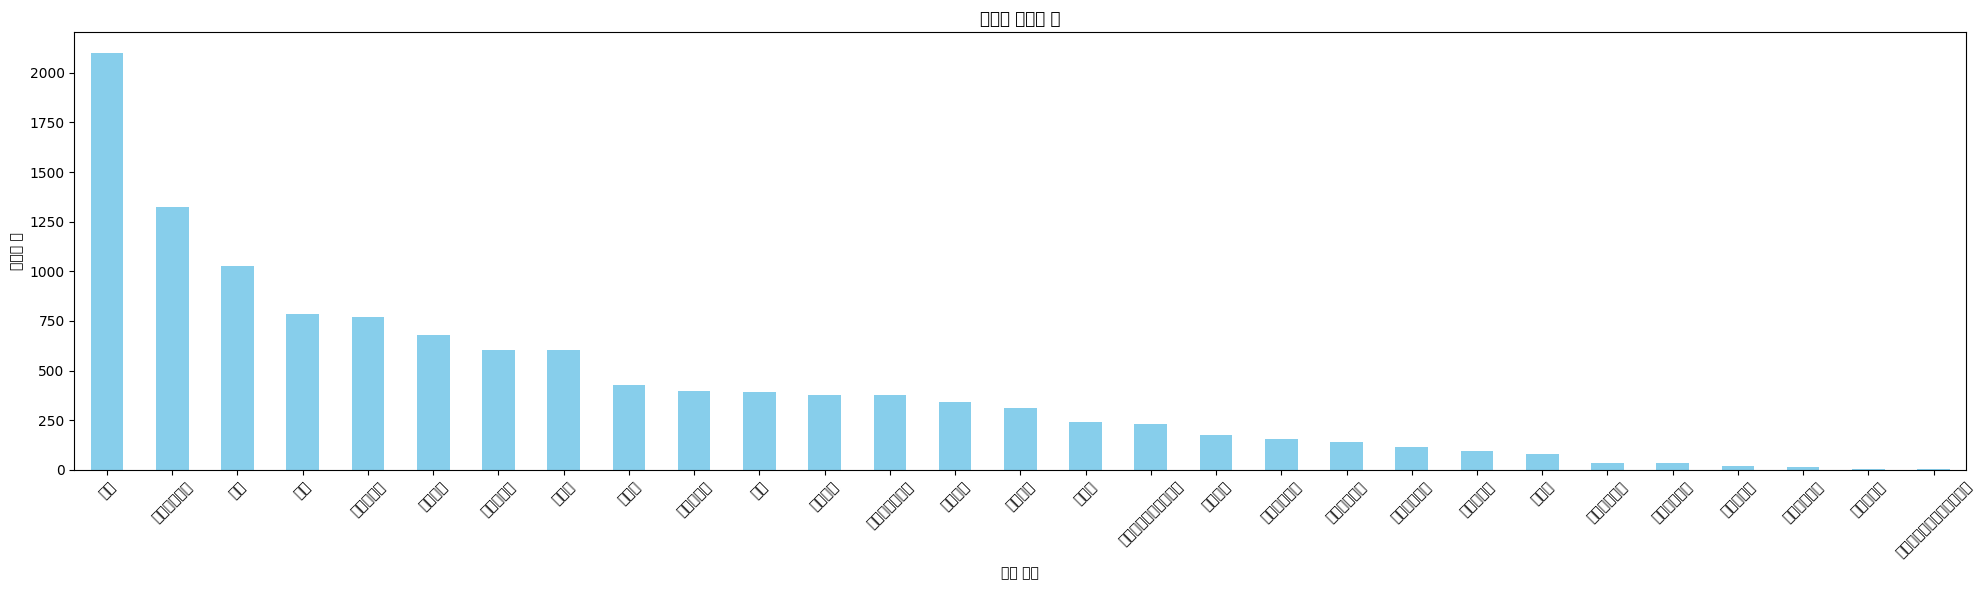

In [ ]:
# 채널별 댓글 게시물 수 집계
channel_counts = df_drama_cleaned['channel_name'].value_counts()

# 막대그래프로 시각화
plt.figure(figsize=(20,6))
channel_counts.plot(kind='bar', color='skyblue')
plt.title('채널별 게시물 수')
plt.xlabel('채널 이름')
plt.ylabel('게시물 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.tight_layout()
<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  plt.tight_layout()
<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 54856 (\N{HANGUL SYLLABLE HOM}) missing from current font.
  plt.tight_layout()
<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 48709 (\N{HANGUL SYLLABLE BIG}) missing from current font.
  plt.tight_layout()
<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  plt.tight_layout()
<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  plt.tight_layout()
<ipython-input-68-bbc73d430bbd>:11: UserWarning: Glyph 4793

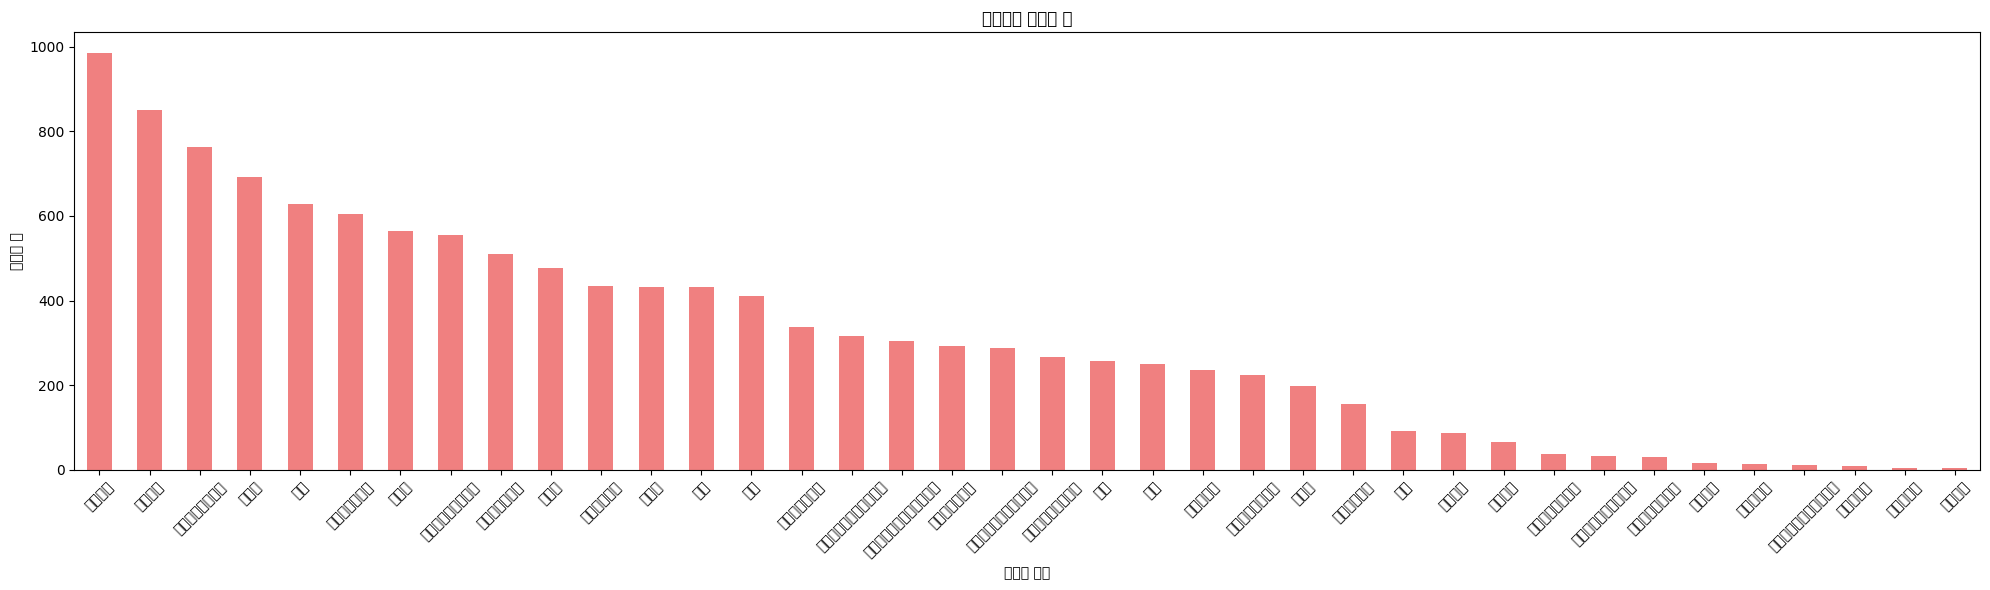

In [ ]:
# 드라마별 댓글 게시물 수 집계
drama_counts = df_drama_cleaned['drama_name'].value_counts()

# 막대그래프로 시각화
plt.figure(figsize=(20,6))
drama_counts.plot(kind='bar', color='lightcoral')
plt.title('드라마별 게시물 수')
plt.xlabel('드라마 이름')
plt.ylabel('게시물 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cf. 드라마별 댓글 게시물 수 집계 해석
- 가장 인기있는 드라마는 커넥트, 간 떨어지는 동거, 불가살, 좋아하면 울리는, 스위트홈, 배드 앤 크레이지, 빅마우스, 빈센조, 마녀 식당으로 오세요, 스물 다섯 스물 하나, 킹덤, 경이로운 소문으로 이룬다.

- 중간 인기는 링크 먹고 사랑하라 죽이게~ 멘탈 코치 제갈길로 이루어진다.

- 가장 낮은 인기는 해피니스~ 블라인드로 이루어진다.

 -> 의견*) 해당 드라마의 OTT 플랫폼은 어디이고, 드라마 출연진, OTT 플랫폼, 영상의 시간, 채널명, 채널 구독자 수, 해당 채널의 특정 장르를 고려할 수 있다.

3.7.3 드라마 연도별 댓글 게시물 수 집계

<ipython-input-69-f3ccc206f6bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drama['year'] = df_drama_cleaned['year'].astype(int)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44172 (\N{HANGUL SYLLABLE GE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyth

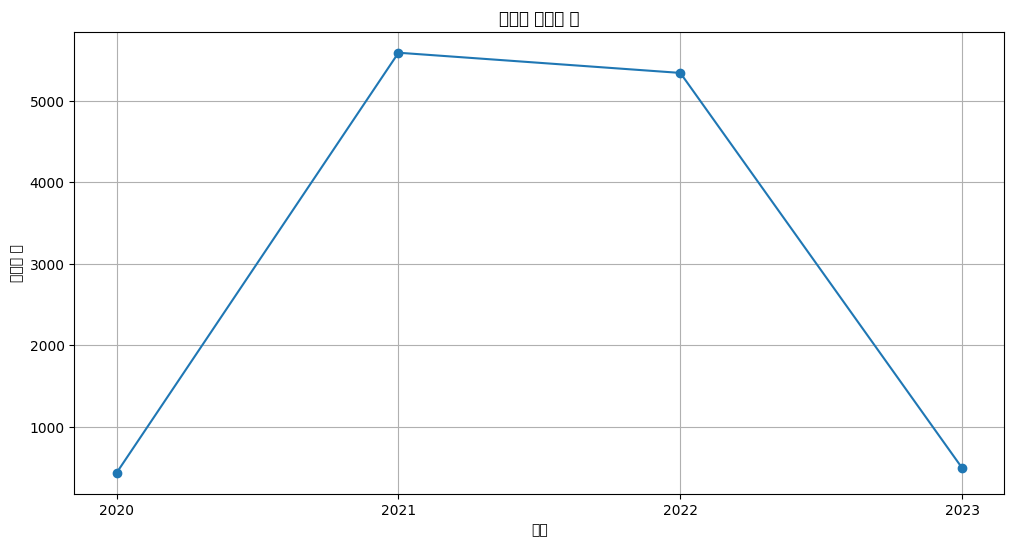

In [ ]:
# 비어있는 문자열('')를 포함하는 행 제거
df_drama = df_drama[df_drama['year'] != '']

# 연도별 게시물 수 집계 (year 컬럼이 문자열일 경우, int로 변환)
df_drama['year'] = df_drama_cleaned['year'].astype(int)
year_counts = df_drama_cleaned['year'].value_counts().sort_index()

# 선그래프로 시각화
plt.figure(figsize=(12,6))
year_counts.plot(kind='line', marker='o', linestyle='-')
plt.title('연도별 게시물 수')
plt.xlabel('연도')
plt.ylabel('게시물 수')
plt.grid(True)
# x축 눈금 설정
plt.xticks(year_counts.index.astype(int))
plt.show()


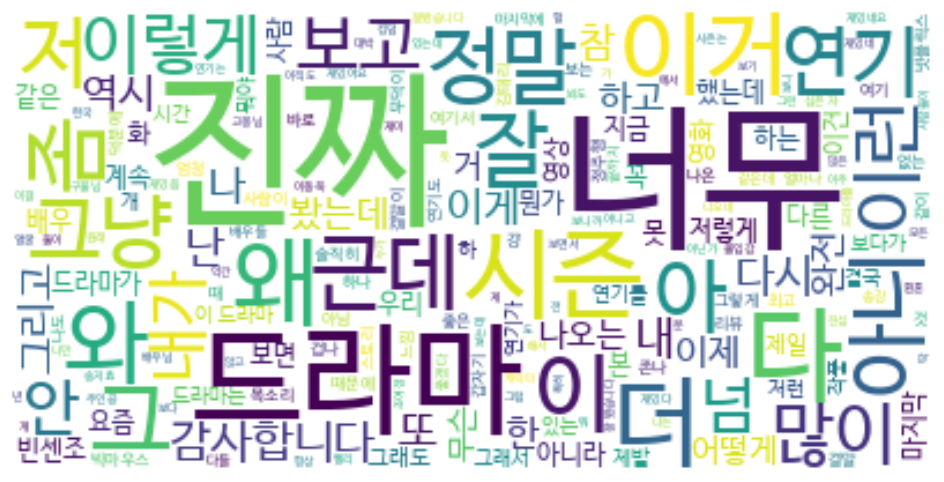

In [ ]:
# 워드클라우드로 시각화

# NaN 값을 공백 문자열로 대체
df_drama_cleaned['text'].fillna('', inplace=True)

# 텍스트 데이터 합치기
text_data = " ".join(text for text in df_drama_cleaned['text'] if isinstance(text, str))

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
    background_color='white'
).generate(text_data)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
index_to_check = 272  # 확인하려는 인덱스

if index_to_check in df_drama_cleaned.index:
    print(f"인덱스 {index_to_check}가 데이터프레임에 존재합니다. 해당 인덱스를 삭제합니다.")
    df_drama_cleaned.drop(index_to_check, inplace=True)  # 해당 인덱스 삭제
else:
    print(f"인덱스 {index_to_check}가 데이터프레임에 존재하지 않습니다.")


인덱스 272가 데이터프레임에 존재합니다. 해당 인덱스를 삭제합니다.


In [ ]:
# 저장

df_drama.to_csv(r'/content/drive/MyDrive/Colab Notebooks/학위_10월/final_comments.csv', index=False)

# ■ 감성 분석 데이터 + 드라마 댓글 데이터 준비



In [ ]:
!pip install ratsnlp
from ratsnlp import nlpbook
nlpbook.set_seed(args)

  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.0
    Uninstalling transformers-4.35.0:
      Successfully uninstalled transformers-4.35.0


set seed: 7


In [ ]:
# 데이터 로드
drama_comments = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/학위_10월/final_comments.csv')

In [ ]:
drama_comments.head()

author                                               text  \
0             김시선  김시선과 함께 tvN 드라마 작은 아씨들 즐기기!!!\n*작은 아씨들 1-2화 보기...   
1             박중근      2:49 왕따일수 없는 이유: 남편이 전요환 잡은 강인구(최창호가 안 도와줬나?)   
2      루돌프사슴코는빨간코                               요즘 누구 주위에 자살죽음 비슷하군.   
3  Maison de MiHo  강아지 광고가 더 감동~~~\n제가 그런 아이와 살고 있어서 ㅎ\n저희도 추운 겨울...   
4            MC댕댕                                            와 개꿀잼이네   

           published_at drama_name channel_name    year  
0  2022-09-08T08:06:24Z      작은아씨들          김시선  2023.0  
1  2023-04-15T15:10:36Z      작은아씨들          김시선  2023.0  
2  2023-03-11T10:29:47Z      작은아씨들          김시선  2023.0  
3  2022-10-19T11:36:25Z      작은아씨들          김시선  2023.0  
4  2022-10-01T05:09:02Z      작은아씨들          김시선  2023.0

In [ ]:
drama_comments = drama_comments.drop(columns=['channel_name'])
drama_comments = drama_comments.drop(columns=['published_at'])
drama_comments = drama_comments.drop(columns=['year'])


In [ ]:
drama_comments.head()

author                                               text  \
0             김시선  김시선과 함께 tvN 드라마 작은 아씨들 즐기기!!!\n*작은 아씨들 1-2화 보기...   
1             박중근      2:49 왕따일수 없는 이유: 남편이 전요환 잡은 강인구(최창호가 안 도와줬나?)   
2      루돌프사슴코는빨간코                               요즘 누구 주위에 자살죽음 비슷하군.   
3  Maison de MiHo  강아지 광고가 더 감동~~~\n제가 그런 아이와 살고 있어서 ㅎ\n저희도 추운 겨울...   
4            MC댕댕                                            와 개꿀잼이네   

  drama_name  
0      작은아씨들  
1      작은아씨들  
2      작은아씨들  
3      작은아씨들  
4      작은아씨들

In [ ]:
# 감성 분석 훈련 데이터 불러오기
with open('/content/drive/MyDrive/Colab Notebooks/학위_10월/02.감성대화말뭉치/감성대화말뭉치(최종데이터)_Training.json','r',encoding='utf-8') as train_file: train_data = json.load(train_file)
# 감성 분석 검증 데이터 불러오기
with open('/content/drive/MyDrive/Colab Notebooks/학위_10월/02.감성대화말뭉치/감성대화말뭉치(최종데이터)_Validation.json','r', encoding='utf-8') as val_file: val_data = json.load(val_file)

In [ ]:
# JSON 데이터를 데이터프레임으로 변환
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

In [ ]:
train_df.head()

profile  \
0  {'persona-id': 'Pro_05349', 'persona': {'perso...   
1  {'persona-id': 'Pro_05349', 'persona': {'perso...   
2  {'persona-id': 'Pro_05349', 'persona': {'perso...   
3  {'persona-id': 'Pro_05349', 'persona': {'perso...   
4  {'persona-id': 'Pro_05349', 'persona': {'perso...   

                                                talk  
0  {'id': {'profile-id': 'Pro_05349', 'talk-id': ...  
1  {'id': {'profile-id': 'Pro_05349', 'talk-id': ...  
2  {'id': {'profile-id': 'Pro_05349', 'talk-id': ...  
3  {'id': {'profile-id': 'Pro_05349', 'talk-id': ...  
4  {'id': {'profile-id': 'Pro_05349', 'talk-id': ...

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51628 entries, 0 to 51627
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   profile  51628 non-null  object
 1   talk     51628 non-null  object
dtypes: object(2)
memory usage: 806.8+ KB


In [ ]:
val_df.head()

profile  \
0  {'persona-id': 'Pro_03802', 'persona': {'perso...   
1  {'persona-id': 'Pro_03802', 'persona': {'perso...   
2  {'persona-id': 'Pro_03802', 'persona': {'perso...   
3  {'persona-id': 'Pro_03802', 'persona': {'perso...   
4  {'persona-id': 'Pro_03802', 'persona': {'perso...   

                                                talk  
0  {'id': {'profile-id': 'Pro_03802', 'talk-id': ...  
1  {'id': {'profile-id': 'Pro_03802', 'talk-id': ...  
2  {'id': {'profile-id': 'Pro_03802', 'talk-id': ...  
3  {'id': {'profile-id': 'Pro_03802', 'talk-id': ...  
4  {'id': {'profile-id': 'Pro_03802', 'talk-id': ...

# ■ 감성분석 훈련/검증 데이터 전처리

In [ ]:
# 데이터 전처리_(1) 필요 없는 중첩 내용 삭제
train_texts = [talk['content']['HS01'] for talk in train_df['talk']]
#train_labels = [int(profile['emotion']['emotion-id'].split('_')[-1].replace('E', '')) for profile in train_df['profile']]
train_labels = [int(data['emotion']['emotion-id'].split('_')[-1].replace('E', '')) for data in train_df['profile']]
# train_texts와 val_texts: 각 대화의 첫 번째 사람의 대화 내용(HS01)을 추출하여 리스트로 저장합니다.
# 예를 들면 "일은 왜 해도 해도 끝이 없을까? 화가 난다."와 같은 대화 내용이 저장됩니다.

val_texts = [talk['content']['HS01'] for talk in val_df['talk']]
#val_labels = [int(profile['emotion']['emotion-id'].split('_')[-1].replace('E', '')) for profile in val_df['profile']]
val_labels = [int(data['emotion']['emotion-id'].split('_')[-1].replace('E', '')) for data in val_df['profile']]
# 각 대화의 감성 id에서 마지막 부분의 'E' 문자를 제거한 후 정수 형태로 변환하여 리스트로 저장합니다.
# 예를 들면, 감성 id가 'S06_D02_E18'인 경우, 'E18' 부분을 추출하여 '18'로 변환 후 정수로 저장합니다.



In [ ]:
# 전처리된 훈련 데이터 출력_(1) 필요 없는 중첩 내용 삭제
print("훈련 데이터 - 대화 내용:")
for i, text in enumerate(train_texts[:10]):  # 처음 5개의 대화 내용만 출력
    print(f"{i+1}. {text}")
print("\n훈련 데이터 - 감성 라벨:")
print(train_labels[:50])  # 처음 5개의 감성 라벨만 출력

훈련 데이터 - 대화 내용:
1. 일은 왜 해도 해도 끝이 없을까? 화가 난다.
2. 이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
3. 회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스트레스 받아. 
4. 직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 섭섭해.
5. 얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
6. 직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.
7. 성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.
8. 퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.
9. 졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.
10. 요즘 직장생활이 너무 편하고 좋은 것 같아!

훈련 데이터 - 감성 라벨:
[18, 18, 18, 18, 18, 18, 18, 66, 37, 66, 66, 35, 35, 35, 50, 50, 50, 50, 25, 25, 25, 25, 64, 64, 64, 42, 42, 49, 49, 56, 56, 10, 10, 10, 10, 10, 30, 30, 30, 30, 22, 22, 40, 19, 19, 19, 19, 19, 19, 19]


In [ ]:
# 60 이상의 감정 라벨 찾기
invalid_labels = [label for label in train_labels if label >= 60]

# 60 이상의 감정 라벨을 가진 예제를 제거합니다.
train_texts = [text for i, text in enumerate(train_texts) if train_labels[i] < 60]
train_labels = [label for label in train_labels if label < 60]

# 제거된 후의 훈련 데이터 출력
print("제거된 후의 훈련 데이터 - 대화 내용:")
for i, text in enumerate(train_texts[:10]):  # 처음 5개의 대화 내용만 출력
    print(f"{i+1}. {text}")
print("\n제거된 후의 훈련 데이터 - 감성 라벨:")
print(train_labels[:50])  # 처음 5개의 감성 라벨만 출력

제거된 후의 훈련 데이터 - 대화 내용:
1. 일은 왜 해도 해도 끝이 없을까? 화가 난다.
2. 이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
3. 회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스트레스 받아. 
4. 직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 섭섭해.
5. 얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
6. 직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.
7. 성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.
8. 졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.
9. 면접에서 부모님 직업에 대한 질문이 들어왔어.
10. 큰일이야. 부장님께 결재받아야 하는 서류가 사라졌어. 한 시간 뒤에 제출해야 하는데 어디로 갔지?

제거된 후의 훈련 데이터 - 감성 라벨:
[18, 18, 18, 18, 18, 18, 18, 37, 35, 35, 35, 50, 50, 50, 50, 25, 25, 25, 25, 42, 42, 49, 49, 56, 56, 10, 10, 10, 10, 10, 30, 30, 30, 30, 22, 22, 40, 19, 19, 19, 19, 19, 19, 19, 32, 20, 20, 20, 20, 20]


In [ ]:
# 60 이상의 감정 라벨 찾기
invalid_labels = [label for label in train_labels if label >= 60]

# 결과 출력
print("60 이상의 감정 라벨:", invalid_labels)


60 이상의 감정 라벨: []


In [ ]:
# 전처리된 검증 데이터 출력_(1) 필요 없는 중첩 내용 삭제
print("\n검증 데이터 - 대화 내용:")
for i, text in enumerate(val_texts[:50]):
    print(f"{i+1}. {text}")
print("\n검증 데이터 - 감성 라벨:")
print(val_labels[:50])


검증 데이터 - 대화 내용:
1. 이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너무 미안해.
2. 회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.
3. 상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.
4. 이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.
5. 직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.
6. 내가 평소에 말이 좀 험한 편인데 무서운 팀장님 앞에서 말실수할까 봐 걱정이야.
7. 내 직급이 낮아서 그런지 회의 시간에 내 의견을 무시하는 경향이 있어서 의견을 제시하는 것이 힘들어.
8. 부장님께 보고서를 올렸는데 혹시 실수한 거 지적당할까 봐 걱정이야.
9. 내일 회사 면접을 보러 가는데 내가 틱 증상이 있어서 불안해. 떨어질까 봐 걱정이야.
10. 친구랑 같이 백수였는데 내가 이번에 취업을 하는 바람에 그 친구와 멀어질까 봐 걱정이야.
11. 내가 새로운 직장에 잘 적응을 할 수 있을지 잘 모르겠어. 불안해.
12. 평소에 날 안 좋게 보시는 팀장님이 있는데 내 아이디어에 대해서 하찮게 여기실까 봐 말을 못 꺼내겠어.
13. 학교에서 애들이 나를 때리는데 엎드려진 상태로 아무것도 할 수 없어서 슬펐어.
14. 내 친구가 나 대신 나섰다가 폭행을 당했다는 소식을 듣고 심장이 멎는 줄 알았어!
15. 내가 많이 의지한 친구가 처벌을 받아서 전학을 갔어. 순간 하늘이 노랗게 보이더라.
16. 친구가 나에 대해서 거짓으로 뭔가를 말해서 선생님한테 불려갔어.
17. 내 친구가 다른 친구한테 맞았대. 그 얘기를 듣고 그 자리에 주저앉아 버렸었어.
18. 학교에서 애들이 나 피하는데 내가 한 말 때문에 그런 거 같아.
19. 학폭위를 통해 정학 조처가 내려졌는데 너무 큰 충격을 받았어.
20. 친구들이 나만 빼고 놀이동산에 다녀왔다네. 그 얘기를 듣는 순간 할 말을 잃었어.
21. 내 편이 되어주던 친구가 변심했는데 아무런 반응을 할 수가 없었어.
22. 내가 따돌

In [ ]:
# 60 이상의 감정 라벨을 가진 예제를 제거합니다.
val_texts = [text for i, text in enumerate(val_texts) if val_labels[i] < 60]
val_labels = [label for label in val_labels if label < 60]
# 결과 출력
print("Invalid Labels:", invalid_labels)


Invalid Labels: []


In [ ]:
# 전처리된 검증 데이터 출력_(2) 특수 문자,숫자, 불용어 리스트 제거
def clean_text(text):
    # 특수 문자, 숫자 제거
    text = re.sub('[^가-힣 ]', '', text)

    return text
# 한국어 불용어 리스트
stopwords = [
    "하", "것", "들", "그", "되", "수", "이", "보", "나", "주",
    "등", "같", "우리", "때", "년", "가", "한", "지", "대하", "오", "말", "위하",
    "두", "알", "그러나", "받", "그런", "또", "더","와","이","의",
    "많", "크", "따르", "중", "나오", "가지", "씨", "시키",
    "적", "월", "데", "자신", "안", "내", "경우", "명","에서","서",
    "번", "나", "다른", "어떻", "여자", "개", "전", "에","해","은","는","가","를","을"
    "들", "이렇", "점", "정도", "원", "잘", "통하", "놓", "씨", "좆", "개",'친','멍','발','지','랄','극','끼'
]


In [ ]:
# 훈련 데이터 전처리
train_texts_cleaned = [clean_text(text) for text in train_texts]
train_texts_cleaned = [' '.join([word for word in text.split() if word not in stopwords]) for text in train_texts_cleaned]
# 전처리된 데이터 출력
print("전처리된 훈련 데이터 - 대화 내용:")
for i, text in enumerate(train_texts_cleaned[:5]):
    print(f"{i+1}. {text}")

전처리된 훈련 데이터 - 대화 내용:
1. 일은 왜 해도 해도 끝이 없을까 화가 난다
2. 이번 달에 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가
3. 회사에 신입이 들어왔는데 말투가 거슬려 애를 매일 봐야 한다고 생각하니까 스트레스 받아
4. 직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 정말 분하고 섭섭해
5. 얼마 입사한 신입사원이 나를 무시하는 같아서 너무 화가


In [ ]:
# 검증 데이터 전처리
val_texts_cleaned = [clean_text(text) for text in val_texts]
val_texts_cleaned = [' '.join([word for word in text.split() if word not in stopwords]) for text in val_texts_cleaned]
print("\n전처리된 검증 데이터 - 대화 내용:")
for i, text in enumerate(val_texts_cleaned[:5]):
    print(f"{i+1}. {text}")


전처리된 검증 데이터 - 대화 내용:
1. 이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 팀이 감점을 받았어 너무 미안해
2. 회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워
3. 상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워
4. 이번에 힘들게 들어간 첫 직장이거든 첫 직장이라서 그런지 너무 긴장된다
5. 직장에서 동료들이랑 관계가 좋아질까 봐 걱정돼


In [ ]:
# 데이터를 DataFrame으로 변환
val_df = pd.DataFrame({'Text': val_texts_cleaned})
train_df = pd.DataFrame({'Text': train_texts_cleaned})

# CSV 파일로 저장
val_df.to_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/05. 표정 분석/validation_data.csv', index=False)  # 검증 데이터 저장
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/학위_10월/05. 표정 분석/training_data.csv', index=False)   # 훈련 데이터 저장

# ■ 드라마 댓글 데이터 사전 학습

In [ ]:
import math

emotion_label = {
    '분노': 0,
    '툴툴대는': 1,
    '좌절한': 2,
    '짜증나는': 3,
    '방어적인': 4,
    '악의적인': 5,
    '안달하는': 6,
    '구역질 나는': 7,
    '노여워하는': 8,
    '성가신': 9,
    '슬픔': 10,
    '실망한': 11,
    '비통한': 12,
    '후회되는': 13,
    '우울한': 14,
    '마비된': 15,
    '염세적인': 16,
    '눈물이 나는': 17,
    '낙담한': 18,
    '환멸을느끼는': 19,
    '불안': 20,
    '두려운': 21,
    '스트레스 받는': 22,
    '취약한': 23,
    '혼란스러운': 24,
    '당혹스러운': 25,
    '회의적인': 26,
    '걱정스러운': 27,
    '조심스러운': 28,
    '초조한': 29,
    '상처': 30,
    '질투하는': 31,
    '배신당한': 32,
    '고립된': 33,
    '충격받은': 34,
    '불운한': 35,
    '희생된': 36,
    '억울한': 37,
    '괴로워하는': 38,
    '버려진': 39,
    '당황': 40,
    '고립된(당황스러운)': 41,
    '남의 시선 의식하는': 42,
    '외로운': 43,
    '열등감': 44,
    '죄책감': 45,
    '부끄러운': 46,
    '혐오스러운': 47,
    '한심한': 48,
    '혼란스러운(당황스러운)': 49,
    '기쁨': 50,
    '감사하는': 51,
    '사랑하는': 52,
    '편안한': 53,
    '만족스러운': 54,
    '흥분되는': 55,
    '느긋한': 56,
    '안도하는': 57,
    '신이난': 58,
    '자신하는': 59,
}


# 드라마별 댓글 분포 딕셔너리
drama_distribution = {
    '커넥트': 1143,
    '간떨어지는동거': 1134,
    '좋아하면울리는': 1086,
    '스위트홈': 1027,
    '배드앤크레이지': 947,
    '빅마우스':877,
    '빈센조':846,
    '마녀식당으로오세요':841,
    '스물다섯스물하나': 799,
    '킹덤':782,
    '경이로운소문':773,
    '링크먹고사랑하라죽이게': 558,
    '마인':552,
    '오피스에서뭐하쉐얼': 515,
    '환혼':495,
    '형사록':481,
    '슈룹':415,
    '지리산':400,
    '유니콘':396,
    '갯마을차차차':392,
    '당신의운명을쓰고있습니다':391,
    '연예인매니저로살아남기':391,
    '미씽':377,
    '멘탈코치제갈길':330,
    '해피니스': 274,
    '살인자의쇼핑목록':264,
    '작은아씨들':237,
    '괴이':184,
    '아다마스': 67,
    '아파트는아름다워':40,
    '조선정신과의사유세풍' : 35,
    '나빌레라': 32,
    '스톡오브하이스쿨':31,
    '덕구이즈백':22,
    '민트컨디션':13,
    '박성실씨의사차산업혁명': 11,
    '바벨신드롬': 3,
    '블라인드': 3
}

# 각 드라마별로 댓글 수의 절반을 가져오는 작업
selected_comments = []
for drama, count in drama_distribution.items():
    half_count = math.ceil(count / 2)  # 올림 함수 사용
    drama_subset = drama_comments[drama_comments['drama_name'] == drama]
    selected_comments.extend(drama_subset['text'][:half_count].tolist())

# BERT 모델 및 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(emotion_label))

# 예측된 감정 라벨을 저장할 리스트 초기화
predicted_labels = []

# 각 댓글 텍스트에 대해 감정 예측 수행
for text in selected_comments:
    inputs = tokenizer([text], return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)

    # 모델의 출력에서 감정 라벨 예측 (가장 큰 값을 선택)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # 예측된 감정 라벨을 저장
    predicted_labels.append(predicted_label)

# 각 댓글의 예측된 감정 라벨을 확인
for i, predicted_label in enumerate(predicted_labels):
    print(f"댓글 {i+1}: 예측된 감정 라벨 - {predicted_label}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
댓글 3394: 예측된 감정 라벨 - 19
댓글 3395: 예측된 감정 라벨 - 19
댓글 3396: 예측된 감정 라벨 - 19
댓글 3397: 예측된 감정 라벨 - 16
댓글 3398: 예측된 감정 라벨 - 19
댓글 3399: 예측된 감정 라벨 - 24
댓글 3400: 예측된 감정 라벨 - 19
댓글 3401: 예측된 감정 라벨 - 24
댓글 3402: 예측된 감정 라벨 - 19
댓글 3403: 예측된 감정 라벨 - 19
댓글 3404: 예측된 감정 라벨 - 16
댓글 3405: 예측된 감정 라벨 - 19
댓글 3406: 예측된 감정 라벨 - 19
댓글 3407: 예측된 감정 라벨 - 19
댓글 3408: 예측된 감정 라벨 - 16
댓글 3409: 예측된 감정 라벨 - 19
댓글 3410: 예측된 감정 라벨 - 19
댓글 3411: 예측된 감정 라벨 - 24
댓글 3412: 예측된 감정 라벨 - 19
댓글 3413: 예측된 감정 라벨 - 19
댓글 3414: 예측된 감정 라벨 - 24
댓글 3415: 예측된 감정 라벨 - 19
댓글 3416: 예측된 감정 라벨 - 19
댓글 3417: 예측된 감정 라벨 - 19
댓글 3418: 예측된 감정 라벨 - 19
댓글 3419: 예측된 감정 라벨 - 19
댓글 3420: 예측된 감정 라벨 - 24
댓글 3421: 예측된 감정 라벨 - 19
댓글 3422: 예측된 감정 라벨 - 24
댓글 3423: 예측된 감정 라벨 - 19
댓글 3424: 예측된 감정 라벨 - 24
댓글 3425: 예측된 감정 라벨 - 19
댓글 3426: 예측된 감정 라벨 - 19
댓글 3427: 예측된 감정 라벨 - 24
댓글 3428: 예측된 감정 라벨 - 19
댓글 3429: 예측된 감정 라벨 - 3
댓글 3430: 예측된 감정 라벨 - 24
댓글 3431: 예측된 감정 라벨 - 24
댓글 3432: 예측된 감정 라벨 - 19
댓글 3433: 예측된 감정 라벨 - 19
댓글 34

In [ ]:
# 예측된 라벨과 댓글을 DataFrame으로 변환
df = pd.DataFrame({
    'comment': selected_comments,
    'predicted_label': predicted_labels
})

# CSV 파일로 저장
df.to_csv('drama_comments_labels.csv', index=False, encoding='utf-8-sig')

### 아래는 메모한 것이므로 무시

cf. **용어 정리** 토큰화

- 토큰화는 자연어 처리의 필수적인 데이터셋 전처리 과정이며, 감성 분석, 텍스트 분류, 기계 번역, 질의 응답의 작업에는 꼭 필요한 단계다.

 이는 원시 텍스트를 모델이 이해할 수 있는 형태로 변환해야한다.

- 토큰화의 과정?

  ㄱ. 분절(Tokeniztion) : 원시 텍스트를 개별 토큰(단어,문자,부분 단어)로 분할

  ㄴ. 정수 인코딩(Integer Encoding) : 각 토큰을 고유한 정수로 변환

  ㄷ. 패딩(Padding) : 모든 텍스트를 동일한 길이로 맞추기

  ㄹ, 다른 전처리 : 공백 제거, 텍스트 변환, 불용어, 특수 문자 제거

 **cf. 용어 정리** 임베딩, 작은 차원, 밀도
  
  ㄱ. 임베딩 )
     
      - 텍스트 데이터를 연속적인 벡터 공간에 표현
      - 자연어는 주로 단어, 문장, 문단 등을 고차원 벡터로 변환하여 컴퓨터가 이해 가능하게 만든다.
      - 벡터를 사용하면 의미적인 유사성과 벡터 간의 거리를 표현 가능하다.
      - 보통, 자연어처리의 전처리 단계에서 진행
      - 관련 라이브러리는 Word2Vec,FastText,GloVc가 있고, 임베딩을 생성하여 컴퓨터가 이해하게 만든다.
  
  ㄴ. 작은 차원)
  
     - 텍스트 데이터는 매우 고차원이며, 10,000개의 단어로 구성되있으면 이를 표현하려면 one-hot 인코딩 방식이 필요하게 되며, 결국 10,000개의 차원의 벡터가 필요하다
     - 반면, 임베딩을 활용하면 좀 더 낮은 차원의 벡터를 사용하게 되고, 이는 계산량의 감소와 메모리 사용량을 감소


  ㄷ. 밀도)

     - one- hot 인코딩 방식은 벡터의 대부분의 원소들이 0의 값을 가지기 때문에 벡터는 희소하다.
     - 그래서 희소 벡터는 많은 정보를 담고 있지 않기 때문에 계산적으로 매우 비효율적이다.
     - 임베딩 방식에서는 각 차원의 실수 값들을 가지게 되고 벡터는 밀집하게 된다.
     - 결과적으로 같은 크기의 벡터라도 임베딩을 하게되면 훨씬 더 많은 정보를 담을 수 있다.


cf. Questions
  
    Q1. 자연어 처리 전처리 단계에서 임베딩은 왜 하는 것인가?

    - 대부분의 머신러닝 알고리즘은 숫자로 된 데이터만 처리
    - 그래서 텍스트 데이터를 숫자 벡터로 변환 필요
    - 이러한 변환은 단어의 유사성과 관계를 수량화 가능
    - 임베딩은 이렇게 단어의 유사성과 관계를 알 수 있는 메커니즘일뿐이다.
    - 장점: 원래의 텍스트보다 더 작은 차원을 가지며, 계산 효율성을 높이고,
      밀도를 증가시킨다.
    
    Q2. BERT는 왜 임베딩이 포함되었는가?

    - BERT는 Transformer 아키텍처를 기반으로 하는 모델입니다.

    - 첫 번째 레이어는 임베딩 레이어로, 각 토큰을 해당 토큰의 임베딩 벡터로 변환

    - 이렇게 변환된 임베딩 벡터는 bert의 나머지 레이어를 통해 처리되며,
    
    - 이 과정에서 문맥을 기반으로 한 토큰의 임베딩이 계속 업데이트 된다
    .
    - BERT에서의 임베딩은 2가지로 나뉠 수 있는데,

      ㄱ.Token Embeddings : 토큰을 벡터로 변환

      ㄴ.Positional Embeddings : 토큰의 위치 정보를 벡터로 변환

    - BERT 와 같은 모델은 토큰화된 입력을 직접 임베딩하는 과정이 내장되었다.

    - 따라서, 별도의 임베딩이 필요 없고, 데이터 토큰화 및 입력 형태를 변환해서 사용한다.

    Q3. 왜 데이터 토큰화 및 입력 형태를 변환해서 사용하는가?

    - BERT는 트랜스포머 기반 모델로 토큰화된 입력을 "직접 임베딩 할 필요가 없다"
    
    - 그러나, 효과적으로 활용하기 위해서는 특정한 입력 형태로 데이터를 준비해야한다.

    - 그렇다면, 왜 데이터의 입력 형태로 변환하나?

     ㄱ. 특수 토큰 활용

      - BERT는 입력 텍스트 앞뒤로 특별한 토큰 [CLS][SEP]를 요구해서 추론에 활용
    
     ㄴ. 특별환 토큰화 방식
     
     - BERT는 WordPiece라는 특별환 토큰화 방식을 활용하여,
       unhappiness가 ##happiness, 또는 ##ness로 분리 가능
      
     ㄷ. 위치 임베딩
     
     - BERT는 LSTM과 같은 순반향 학습이 아닌, 양방향 학습이기 때문에,
       위치 정보를 제공한다. 그래서 positional encoding이 필요하다.

      ㄹ. Segment 정보

      - 두 개의 문장을 입력 받을 수 있으며(문장 유사도 태스크),
        두 문장을 구분하기 위해 Segment가 필요하다.

      ㅁ. Attention Mask

      - BERT의 입력 길이는 고정적이다. 원본 텍스트의 길이가 이보다 짧으면
        나머지 길이를 채우고, 이 패딩 토큰은 실제 정보가 아니기 때문에
        모델이 이를 무시하도록 Attention Mask를 사용한다.
         


cf. 5.3.1. 훈련 데이터 토큰화 과정 설명

1. tokenize_function(examples)은 examples의 대화 내용을 토큰화 한다.

2. texts : 대화 데이터에서 각 대화의 내용을 연결해서 하나의 문자로열로 만든다.

           단, 빈문자열은 제외한다.

3. tokenizer : BERT 토크나이저를 사용하여 텍스트를 토큰화한다.

4. tokenizer 인자 설명

  - truncation = True : 주어진 최대 시퀀스 길이를 초과하는 토큰을 자르기
  
  - padding = max_length : 모든 시퀀스가 동일한 길이를 갖도록 패딩

  - max_length =128  시퀀스의 길이를 지정

  - return_tensors = pt결과를 PyTorch 텐서로 변환
5. train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)

 - pandas DataFrame을 HuggingFace의 Dataset 객체로 변환한다,

 - .map(tokenize_function, batched=True) :
   객체의 각 요소에  tokenize_function을 적용하여 데이터를 토큰화한다.
  
 - batched=True는 데이터를 배치로 처리하도록 지시.


 5.3.2. 검증 데이터 토큰화

 cf. 5.3.2. 평가 데이터 토큰화 과정 설명

val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

상기와 같이 검증 데이터셋에 동일한 처리를 한다.

즉, 훈련 & 검증 데이터셋의 대화 내용을 BERT 모델의 입력 형식에 맞춰 토큰화하고 준비한다.

훈련, 검증 데이터 셋 텐서를 추출하고 데이터 로더로 변환

Questions

Q1 .훈련, 검증 데이터 셋의 텐서를 추출하고, 왜 데이터 로더로 변환 했는가?

1. 배치 처리
: 대부분의 딥 러닝 모델은 한 번에 전체 데이터셋을 학습하는 대신,
데이터의 작은 배치를 나누어서 학습한다. 이러한 배치 처리를 자동화 시킨다.

2. 셔플링
: 각 학습 횟수(Epoch)마다 데이터의 순서를 무작위로 섞어 학습을 효율적으로 만들어, 일반화 능력을 향상

3. 멀티스레딩 및 병렬 처리
: 데이터 로더는 멀티스레딩을 지원하여 데이터 로딩 속도를 개선한다.
이는 입출력(I/O) 바운드 작업에서 중요하며, GPU 같은 연산 자원이 데이터를 기다리지 않도록 한다,

4. 메모리 효율
: 전체 데이터셋을 메모리에 로딩하는 대신, 데이터로더는 필요할 때마다 배치를 메모리에 할당하여 메모리 효율성 유지 가능

즉, 학습 및 검증을 위해 데이터를 효율적으로 제공한다.